# Libraries, Modules and Configuration File

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

from datetime import datetime
from tqdm import tqdm
import joblib
import sys
sys.path.append('/root/ml_process_feb23/')
import src.util as utils
config = utils.load_config()
import json
import copy
import hashlib

import warnings
warnings.filterwarnings('ignore')

# Data Pipeline

## Data Collection

In [2]:
# Loading dataset
credit_data = pd.read_csv(config["dataset_original_path"])
credit_data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


## Data Definition

In [3]:
# Check the DataFrame information
credit_data.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Columns: 12 entries, card to active
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


From the information shown above, I comprehend a general 
insight into the `credit_data`.






It has 1319 rows and 12 features, which consist of 9 numerical features, and 3 numerical categorical features.








In [4]:
# Check the features name
credit_data.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

Features definition:


*   `card`: Acceptance status of credit card application
*   `reports`: Number of major derogatory reports
*   `age`: Age, in years plus twelfths of a year
*   `income`: Yearly income (divided by 10,000)
*   `share`: Ratio of monthly credit card expenditure to yearly income
*   `expenditure`: Average monthly credit card expenditure
*   `owner`: Home ownership
*   `selfempl`: Self-employed status, "no" means an employee to a company
*   `dependents`: Number of dependents
*   `months`: Months living at current address
*   `majorcards`: Number of major credit cards held
*   `active`: Number of active credit accounts








## Data Validation

### Checking Null Values and Data Types in Each Feature

In [5]:
# Check the detailed DataFrame information
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


There is no null value in this dataset.

The object (string) data types will be later converted to numeric.

### Checking The General Data Distribution

In [6]:
# Check the distribution of numerical features
credit_data.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


Notes on the numerical data.
*  The counts in the entire features are the same value, meaning that `credit_data` has no null value.
* The minimum age recorded is 2 months old, which is consciously impossible to apply for a credit card at that age.
* Applicant(s) who have zero expenditure will also be checked thoroughly later to make sure the data is correctly filled in.





In [7]:
# Check the distribution of categorical features
credit_data.describe(include=['O'])

,card,owner,selfemp
count,1319,1319,1319
unique,2,2,2
top,yes,no,no
freq,1023,738,1228


All the categorical features have the binary value, "yes" and "no".

### Data Deletion

The legal age to have a credit card is 18 years old, thus the data in feature `age` valued at less than 18 will be dropped.

I decide to do this deletion work in advance to set the minimum limit of data range in the data defense.

In [8]:
def del_rows(dataset, col, value):
    """A function for deleting data in numeric column,
    specify by the value"""
    
    dataset = dataset.loc[dataset[col] >= value].reset_index(drop = True)
    return dataset

In [9]:
# Execute the data deletion function
credit_data = del_rows(credit_data, 'age', 18)

## Data Defense

Create a defense mechanism for the input data.

In [10]:
def check_data(input_data, config):

    # Check data types
    assert input_data.select_dtypes("object").columns.to_list() == config["object_columns"], "input error, please fill the column(s) with 'yes' or 'no'"
    assert input_data.select_dtypes("int").columns.to_list() == config["int_columns"], "input error, please fill the column(s) with any numeric character."
    assert input_data.select_dtypes("float").columns.to_list() == config["float_columns"], "input error, please fill the column(s) with any numeric (decimal value is allowed) character."

    # Check range of data
    assert set(input_data[config["object_columns"][1]]).issubset(set(config["range_owner"])), "an error occurs in owner range."
    assert set(input_data[config["object_columns"][2]]).issubset(set(config["range_selfemp"])), "an error occurs in selfemp range."
    assert input_data[config["int_columns"][0]].between(config["range_reports"][0], config["range_reports"][1]).sum() == len(input_data), "an error occurs in reports range."
    assert input_data[config["float_columns"][0]].between(config["range_age"][0], config["range_age"][1]).sum() == len(input_data), "an error occurs in age range."
    assert input_data[config["float_columns"][1]].between(config["range_income"][0], config["range_income"][1]).sum() == len(input_data), "an error occurs in income range."
    assert input_data[config["float_columns"][2]].between(config["range_share"][0], config["range_share"][1]).sum() == len(input_data), "an error occurs in share range."
    assert input_data[config["float_columns"][3]].between(config["range_expenditure"][0], config["range_expenditure"][1]).sum() == len(input_data), "an error occurs in expenditure range."
    assert input_data[config["int_columns"][1]].between(config["range_dependents"][0], config["range_dependents"][1]).sum() == len(input_data), "an error occurs in dependents range."    
    assert input_data[config["int_columns"][2]].between(config["range_months"][0], config["range_months"][1]).sum() == len(input_data), "an error occurs in months range."
    assert input_data[config["int_columns"][3]].between(config["range_majorcards"][0], config["range_majorcards"][1]).sum() == len(input_data), "an error occurs in majorcards range."
    assert input_data[config["int_columns"][4]].between(config["range_active"][0], config["range_active"][1]).sum() == len(input_data), "an error occurs in active range."
   


In [11]:
# checking the data defense function
check_data(credit_data, config)

## Data Splitting

In [12]:
def split_input_output(dataset,
                       target_column,
                       save_file = True,
                       return_file = True):
    """Divide the data into its dependent variable/target (y-axis) and independent/predictor (x-axis) ones,
    input_df = predictors while output_df = target"""

    output_df = dataset[target_column]
    input_df = dataset.drop([target_column],
                            axis = 1)

    if save_file:  
        utils.pkl_dump(output_df, config["dataset_output_df_path"])
        utils.pkl_dump(input_df, config["dataset_input_df_path"])
    
    if return_file:
        return output_df, input_df


def split_train_test(x, y, TEST_SIZE):
    """Split the data into the training and test data,
    stratify parameter is activated,
    this function will be reproduced later as the data-splitting process further"""
    
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=TEST_SIZE,
                                                        random_state=46,
                                                        stratify=y)

    return x_train, x_test, y_train, y_test

def split_data(data_input, 
               data_output, 
               save_file = True,
               return_file=True, 
               TEST_SIZE=0.17):
    """Split the data into the training, validation and test data,
    first split process will return into the train and test data,
    the train data resulted from the first will be splitted further into the train and validation data.
    The TEST_SIZE 0.17 resulting the test data 17% proportion from the dataset length,
    while the proportion of train data and validation data are respectively 69% and 14%. 
    All files returned from this function are saved into pickle files."""

    x_train, x_test, y_train, y_test = split_train_test(data_input, 
                                                        data_output,
                                                        TEST_SIZE)

    x_train, x_valid, y_train, y_valid = split_train_test(x_train,
                                                          y_train,
                                                          TEST_SIZE)
    
    if save_file:
        utils.pkl_dump(x_train, config["dataset_train_path"][0])
        utils.pkl_dump(y_train, config["dataset_train_path"][1])
        utils.pkl_dump(x_valid, config["dataset_valid_path"][0])
        utils.pkl_dump(y_valid, config["dataset_valid_path"][1])
        utils.pkl_dump(x_test, config["dataset_test_path"][0])
        utils.pkl_dump(y_test, config["dataset_test_path"][1])

    if return_file:
        return x_train, y_train, \
            x_valid, y_valid, \
            x_test, y_test

In [13]:
# Execute the data-splitting functions

output_df, input_df = split_input_output(credit_data,
                                        target_column = "card", 
                                        save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                               output_df)

## Data Review

The "credit" feature in `credit_data` is set as the dependent variable (saved as output_df), while the rest features are the independent variables (saved as input_df).

In [14]:
# Recheck the division of the dependent and independent variables from the `credit_data`
print(f'The dependent variable (target):\n{output_df} \n')
print("-------------------------------------\n")
print(f'The independent variables (predictors):\n {input_df}')

The dependent variable (target):
0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
1307    yes
1308     no
1309    yes
1310    yes
1311    yes
Name: card, Length: 1312, dtype: object 

-------------------------------------

The independent variables (predictors):
       reports       age  income     share  expenditure owner selfemp  \
0           0  37.66667  4.5200  0.033270   124.983300   yes      no   
1           0  33.25000  2.4200  0.005217     9.854167    no      no   
2           0  33.66667  4.5000  0.004156    15.000000   yes      no   
3           0  30.50000  2.5400  0.065214   137.869200    no      no   
4           0  32.16667  9.7867  0.067051   546.503300   yes      no   
...       ...       ...     ...       ...          ...   ...     ...   
1307        0  33.58333  4.5660  0.002146     7.333333   yes      no   
1308        5  23.91667  3.1920  0.000376     0.000000    no      no   
1309        0  40.58333  4.6000  0.026513   101.298300   yes     

Both the `input_df` and `output_df` are split into three data that will be used for training, validation, and testing the model.

The training data has the majority proportion.

In [15]:
# Inspect the data-splitting result
print(f"input_df shape: {input_df.shape}")
print(f"x_train shape: {x_train.shape}")
print(f"x_valid shape:{x_valid.shape}")
print(f"x_test shape: {x_test.shape}\n")
print("-------------------------------------\n")
print(f"output_df shape: {output_df.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"y_test shape: {y_test.shape}")


input_df shape: (1312, 11)
x_train shape: (903, 11)
x_valid shape:(185, 11)
x_test shape: (224, 11)

-------------------------------------

output_df shape: (1312,)
y_train shape: (903,)
y_valid shape: (185,)
y_test shape: (224,)


The stratified splitting method applies to the `output_df` to keep the value proportion approximately the same.

In [16]:
# Recheck the data stratification
print(f"y_train value proportion\n{y_train.value_counts(normalize = True)}")
print("-------------------------------------\n")
print(f"y_valid value proportion\n{y_valid.value_counts(normalize = True)}")
print("-------------------------------------\n")
print(f"y_test value proportion\n{y_test.value_counts(normalize = True)}")

y_train value proportion
yes    0.775194
no     0.224806
Name: card, dtype: float64
-------------------------------------

y_valid value proportion
yes    0.772973
no     0.227027
Name: card, dtype: float64
-------------------------------------

y_test value proportion
yes    0.776786
no     0.223214
Name: card, dtype: float64


# Exploratory Data Analysis (EDA)

## Inspecting the data distribution.

The EDA works are applied only for the training data.

In [17]:
# Loading Dataset 
x_train = utils.pkl_load(config["dataset_train_path"][0])
y_train = utils.pkl_load(config["dataset_train_path"][1])

EDA_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
utils.pkl_dump(EDA_df, config["dataset_EDA_path"])

# Separate the numerical and categorical data types
numerical_columns = EDA_df._get_numeric_data().columns
categorical_columns = (EDA_df.drop(numerical_columns, axis=1)).columns.values.tolist()

In [18]:
# Create the function for data visualization.
def draw_histograms(EDA_df, features, n_rows, n_cols, bins):
    """A function to visualize the multiple graphs of the features
    for an introductory observation to the dataset"""
    fig = plt.figure()
    for i, var_name in enumerate(features):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        EDA_df[var_name].hist(bins = bins, ax=ax, color = 'green', figsize = (50, 50))
        ax.set_title(var_name, fontsize = 50)
        ax.tick_params(labelsize = 40, grid_alpha = 0.7)
    fig.tight_layout() 
    plt.show()

### Numerical Data Distribution.

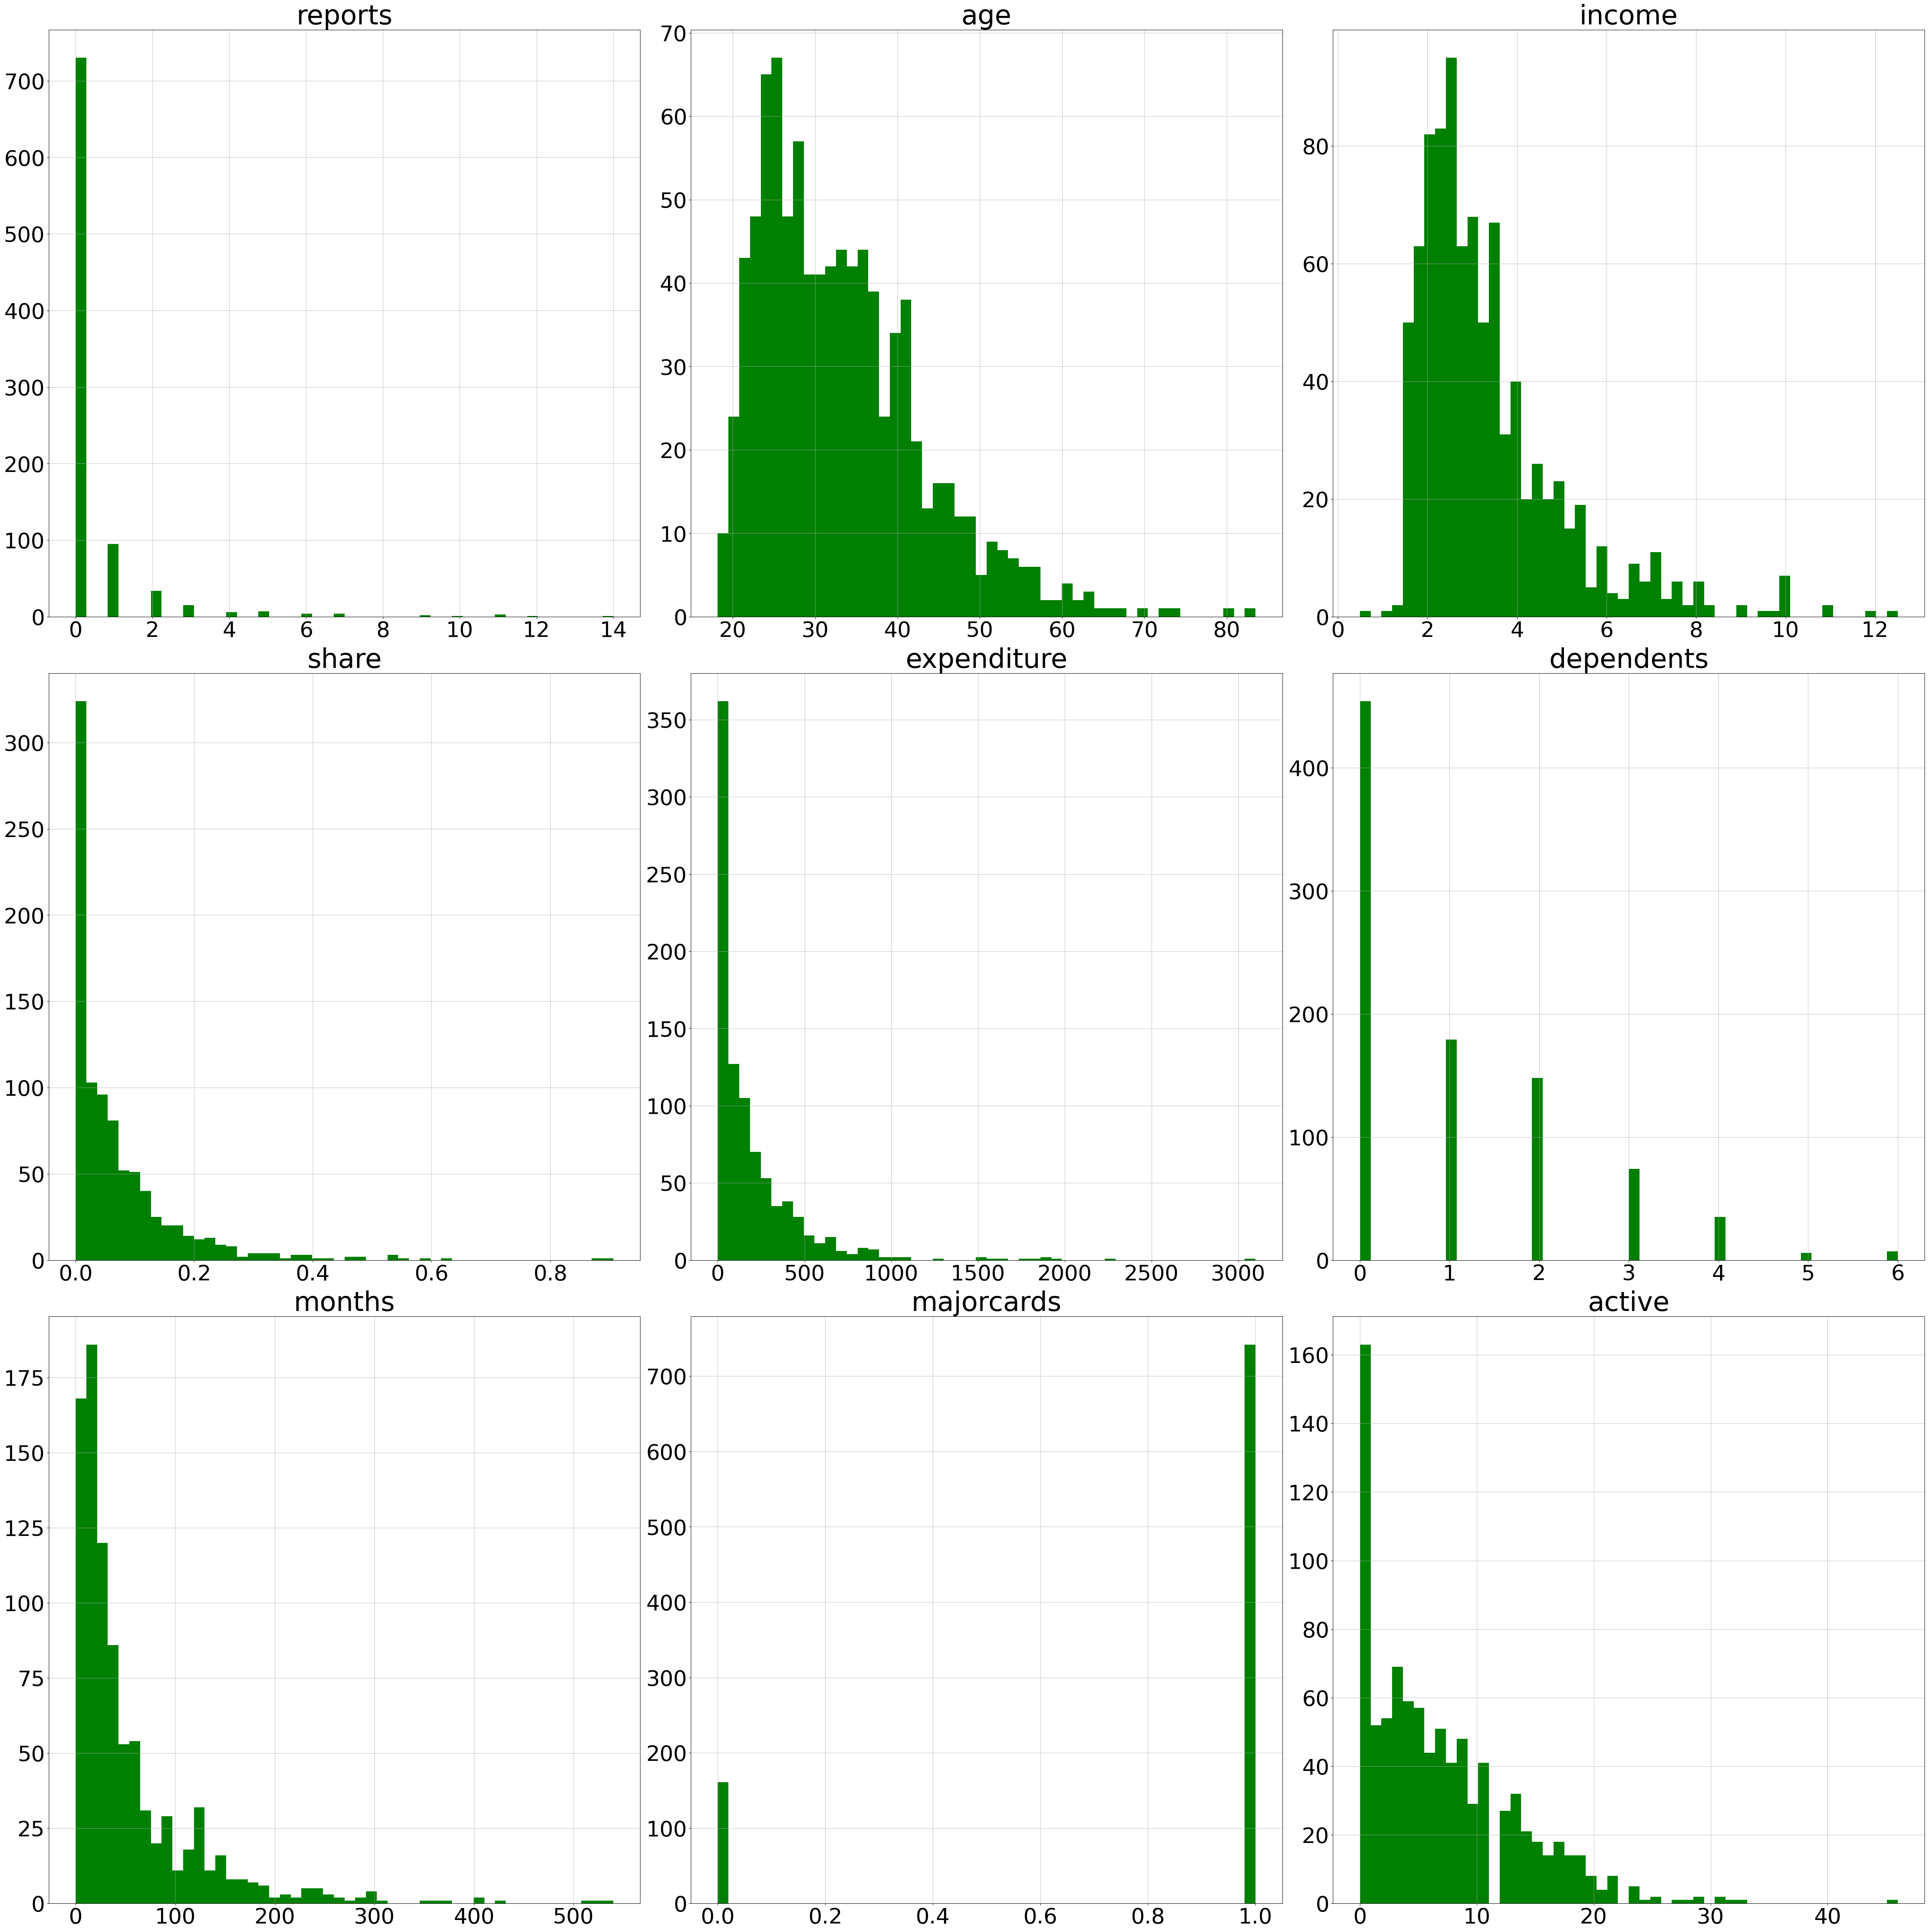

In [19]:
# Visualize the numerical data distribution
draw_histograms(EDA_df, numerical_columns, 3, 3, 50)

Next, I will analyze deeper into the numerical columns.

#### Detail EDA on each feature.

In [20]:
# Create the function for specific numerical column data visualization.
def check_dist(col, bins=50, density=False, plot_normal=True, log_bins=False):
  """A function to visualize the graph for inspecting each feature thoroughly,
  in addition to the basic bar plot of the feature, the graph also shows the normal distribution curve, mean and median vertical lines.
  The correlation to the dependent/target feature is visualized by the KDE plot."""

  x = EDA_df[col]
  TARGET = EDA_df['card']

  fig, ax = plt.subplots(figsize=(8,6))
  fig.suptitle(f"Distribution of {str(col).upper()}")
  sns.distplot(x, axlabel=x.name, color = "green")
  sns.kdeplot(EDA_df.loc[TARGET == "yes", col] , label = 'Approved')
  sns.kdeplot(EDA_df.loc[TARGET == "no", col] ,  label = 'Not Approved')
  line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
  line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
  first_legend = plt.legend(handles=[line1,line2], loc=1)

  if plot_normal == True:
    mu, std = stats.norm.fit(x)
    xmin, xmax = plt.xlim()
    x_norm = np.linspace(xmin, xmax, 100)
    pdf = stats.norm.pdf(x_norm, mu, std)
    ax.plot(x_norm, pdf, 'k', linewidth=2, label=f"normal distribution\n(mu=mean, std:{std:.2f}")

  ax.legend()
  fig.show()
  print(x.describe())
  print("Median:", x.median())

##### reports

count    903.000000
mean       0.449612
std        1.396645
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       14.000000
Name: reports, dtype: float64
Median: 0.0


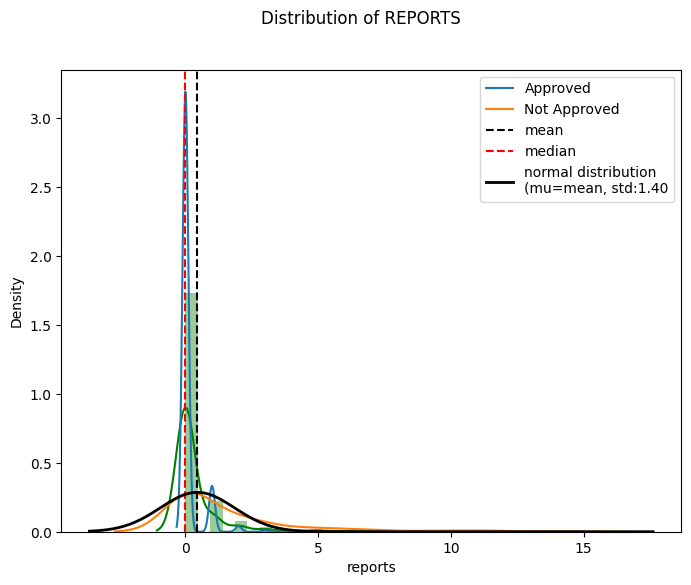

In [21]:
check_dist(numerical_columns[0])

Most applicants have no major derogatory reports.

##### age

count    903.000000
mean      33.228313
std        9.955114
min       18.166670
25%       25.250000
50%       31.500000
75%       38.916670
max       83.500000
Name: age, dtype: float64
Median: 31.5


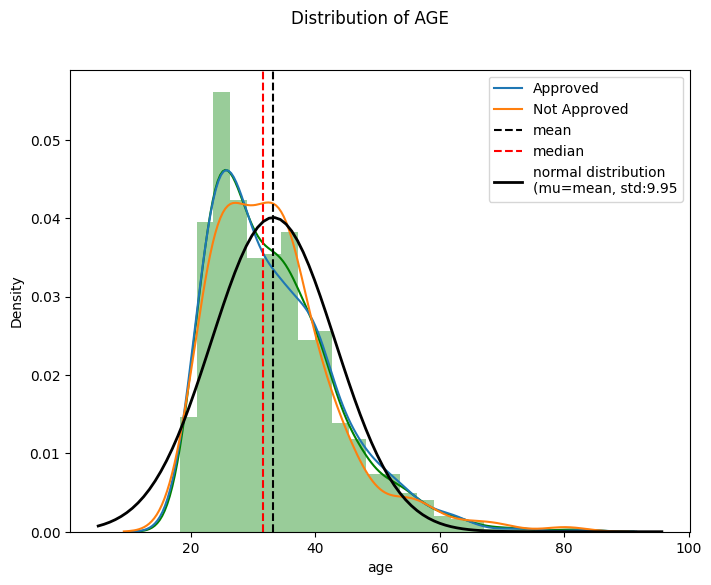

In [22]:
check_dist(numerical_columns[1])

This feature is already handled by dropping the data valued under 18 in the Data Pipeline chapter.


##### income

count    903.000000
mean       3.384004
std        1.678448
min        0.490000
25%        2.250000
50%        2.950000
75%        4.000000
max       12.499900
Name: income, dtype: float64
Median: 2.95


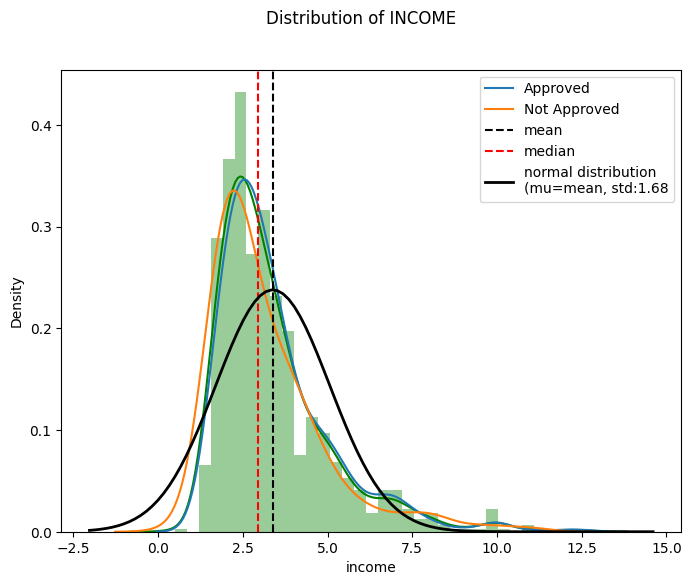

In [23]:
check_dist(numerical_columns[2])

The values shown in this feature are divided by 10,000.

There are some notable occurrence of applicants whose incomes are around 10, we need to inspect it further.

In [24]:
EDA_df.loc[(EDA_df['income'] >= 10)]


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
85,0,45.58333,11.9999,0.020066,200.49330,yes,yes,1,24,1,6,yes
359,1,32.50000,10.0000,0.037040,308.25000,yes,no,3,35,1,4,yes
441,0,31.75000,10.9999,0.010701,97.42416,no,no,0,12,1,0,yes
584,0,51.58333,12.4999,0.297555,3099.50500,yes,no,1,120,1,21,yes
645,0,53.00000,11.0000,0.000109,0.00000,yes,yes,0,429,1,0,no
861,0,43.66667,10.0393,0.021863,182.82500,yes,no,1,12,1,18,yes


The higher income means the more probable the application to be approved.

Moreover, the applicant's income is more than $100,000 per year, the probability of an application being approved is near 100%.

We can see the exception at the table above, the only one applicant whose income more than $100,000 per year and not approved have zero expenditure.

I decide to keep all the data in this feature, perhaps the model will the threshold of approval decision at 10 or there will be any significant weight from another feature that can affect the approval decision.

##### share

count    903.000000
mean       0.071685
std        0.098974
min        0.000109
25%        0.002437
50%        0.040651
75%        0.097109
max        0.906320
Name: share, dtype: float64
Median: 0.04065079


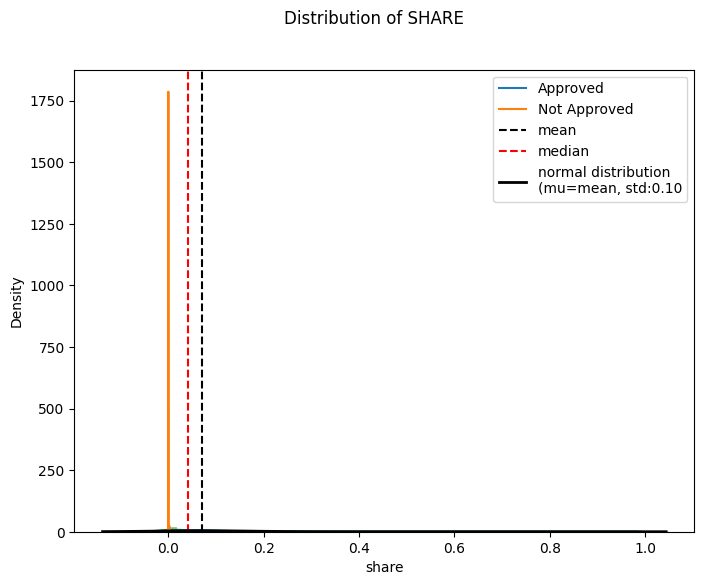

In [25]:
check_dist(numerical_columns[3])

Since I do not get a clear comprehension of the graph, I use the statistical data distribution information to inspect this feature.

Let's inspect the approval proportion from every quartile in this feature.

In [26]:
print(f"The approval proportion of Q4 data: \n{EDA_df.loc[(EDA_df['share'] >= 0.094165)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of Q3 data: \n{EDA_df.loc[(EDA_df['share'] >= 0.0387775) | (EDA_df['share'] <= 0.094165)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of Q1 and Q2 data: \n{EDA_df.loc[(EDA_df['share'] <= 0.0387775)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of the entire training data: \n{EDA_df.card.value_counts(normalize=True)}")

The approval proportion of Q4 data: 
yes    1.0
Name: card, dtype: float64
-------------------------------------

The approval proportion of Q3 data: 
yes    0.775194
no     0.224806
Name: card, dtype: float64
-------------------------------------

The approval proportion of Q1 and Q2 data: 
yes    0.541761
no     0.458239
Name: card, dtype: float64
-------------------------------------

The approval proportion of the entire training data: 
yes    0.775194
no     0.224806
Name: card, dtype: float64


The higher proportion of income spent via credit card means the more probable the application to be approved.

Moreover, if credit card expenditure is more than 9.4165% of income, the probability of an application being approved is 100%.

I decide to keep all the data in this feature, perhaps the model will set the threshold of approval decision at 0.094165 or there will be any significant weight from another feature that can affect the approval decision.



##### expenditure

count     903.000000
mean      194.336055
std       287.297197
min         0.000000
25%         5.364583
50%       105.507500
75%       265.921250
max      3099.505000
Name: expenditure, dtype: float64
Median: 105.5075


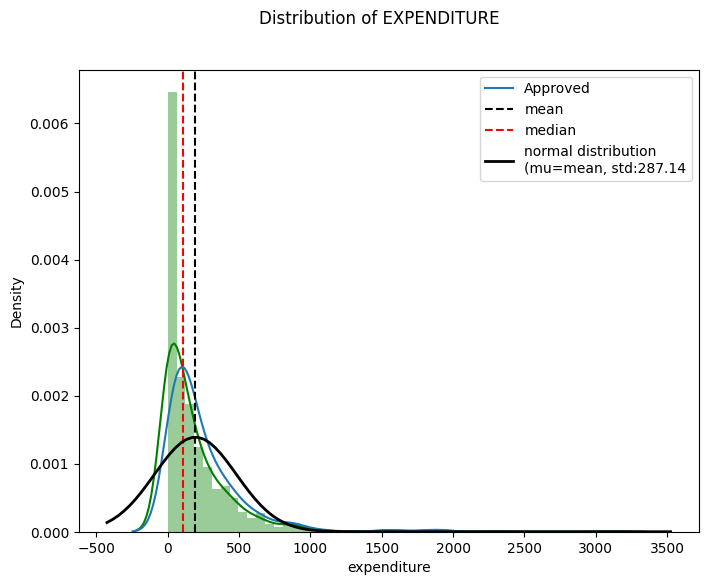

In [27]:
check_dist(numerical_columns[4])

Let's check the applicants with zero expenditure.

In [28]:
print(f"The approval proportion zero expenditure applicants: \n{EDA_df.loc[(EDA_df['expenditure'] == 0)].card.value_counts(normalize=True)}")

The approval proportion zero expenditure applicants: 
no     0.931193
yes    0.068807
Name: card, dtype: float64


Most of them are not approved to have the credit card.

Let's check the minority ones, the approved applicants.

In [29]:
EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')]

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
71,0,29.00000,2.7000,0.000444,0.0,no,no,0,24,1,20,yes
233,0,19.50000,2.9800,0.000403,0.0,no,no,0,18,1,0,yes
241,0,49.16667,1.7000,0.000706,0.0,no,no,1,14,0,6,yes
410,0,23.00000,2.9000,0.000414,0.0,no,no,1,12,1,0,yes
451,0,29.08333,2.2000,0.000545,0.0,no,no,0,9,1,0,yes
510,1,48.75000,2.7000,0.000444,0.0,no,yes,0,120,1,3,yes
511,0,19.83333,3.0000,0.000400,0.0,no,no,0,49,1,3,yes
562,0,25.00000,3.3984,0.000353,0.0,yes,no,2,29,0,4,yes
583,0,61.58333,3.7500,0.000320,0.0,yes,no,0,288,1,5,yes
759,0,53.50000,1.5000,0.000800,0.0,yes,no,0,57,0,6,yes


From the table above, they are dominantly not self-employed and already held a credit card.

Perhaps the selfemp and majorcards features are decisive for the applicants with zero expenditure.

To prove it, let's observe the comparison between the approved and the not-approved ones.



In [30]:
print("Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].majorcards.value_counts(normalize=True)}")
print("_________________________________\n")
print("Not-Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].majorcards.value_counts(normalize=True)}")

Approved applicants

Self-employed status: 
no     0.933333
yes    0.066667
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.8
0    0.2
Name: majorcards, dtype: float64
_________________________________

Not-Approved applicants

Self-employed status: 
no     0.901478
yes    0.098522
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.738916
0    0.261084
Name: majorcards, dtype: float64


There is no significant difference, so the `selfemp` and `majorcards` features are not the major decisive detail.

I am determined to keep the zero expenditures data for the training process.

##### dependents

count    903.000000
mean       1.006645
std        1.282649
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


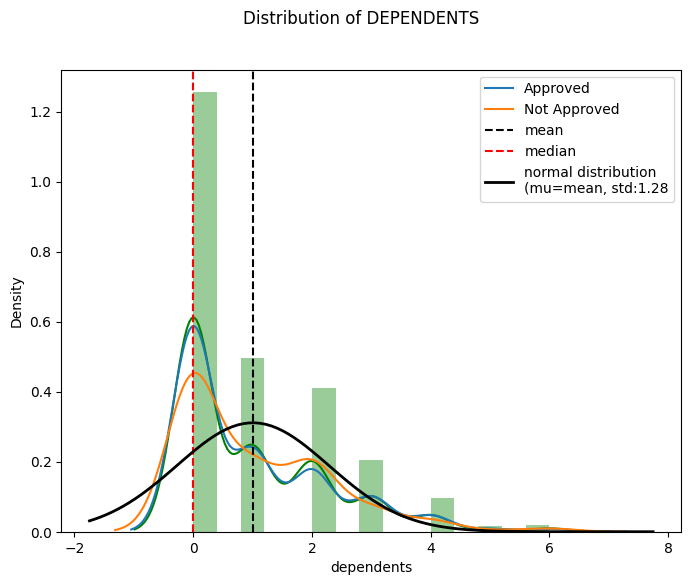

In [31]:
check_dist(numerical_columns[5])

Simply by reading the kdeplot of the approval decision, we can see that the probability of approved application is higher in every value of dependents, except in value 2.

Let's check the approval probability for the applicants in the highest quartile data, who have more than 2 dependents:




In [32]:

print(EDA_df.loc[(EDA_df['dependents'] > 2)].dependents.value_counts()\
                                            .rename_axis('number of dependents')\
                                            .to_frame('counts'))
print("_________________________________\n")
print("Approval decision for applicants with more than 2 dependents")
counts = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts()
counts.name = 'counts'
approval = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)


                      counts
number of dependents        
3                         74
4                         35
6                          7
5                          6
_________________________________

Approval decision for applicants with more than 2 dependents


,%,counts
yes,80.33,98
no,19.67,24


In [33]:
print("Approval proportion of the entire training data")
counts = EDA_df.card.value_counts()
counts.name = 'counts'
approval = EDA_df.card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)


Approval proportion of the entire training data


,%,counts
yes,77.52,700
no,22.48,203


The applicants with more than 2 dependants even have higher possibility to be approved than the entire training data, thus I assume that the `dependents` feature are not the major decisive detail, and will keep it for the training process.

##### months

count    903.000000
mean      54.863787
std       68.573267
min        0.000000
25%       12.000000
50%       30.000000
75%       69.500000
max      540.000000
Name: months, dtype: float64
Median: 30.0


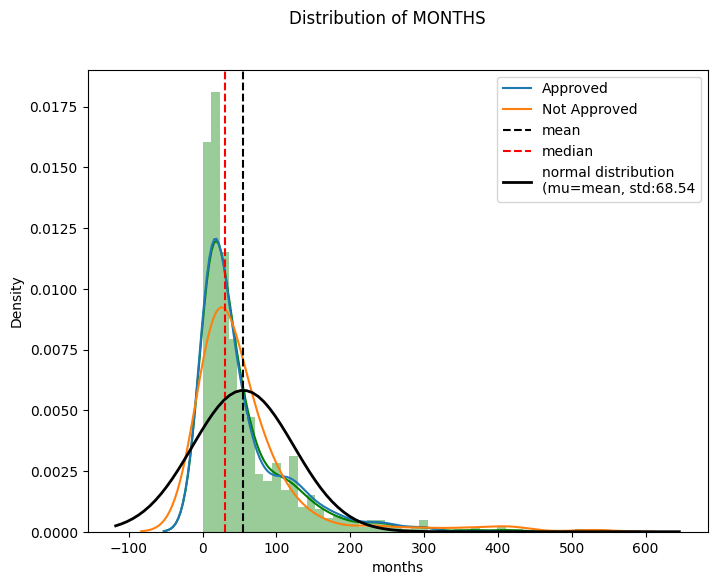

In [34]:
check_dist(numerical_columns[6])

This feature has a very wide range, let's inspect further the far distributed data to specify the outlier.

I roughly set the boundary at value 275.

In [35]:
EDA_df.loc[(EDA_df['months'] > 275)]

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
111,1,56.91667,3.4838,0.062895,182.09580,yes,no,0,540,1,7,yes
287,1,55.33333,3.7000,0.052201,160.45170,yes,no,1,300,1,4,yes
376,1,53.66667,4.1800,0.000287,0.00000,no,no,1,288,1,2,no
383,1,56.75000,8.0000,0.000150,0.00000,yes,no,0,408,1,7,no
422,0,61.00000,1.5000,0.268517,335.56250,yes,no,1,372,1,24,yes
431,1,29.00000,2.7000,0.000444,0.00000,no,no,1,347,0,1,no
439,0,69.75000,1.8000,0.000667,0.00000,yes,no,0,528,0,5,no
485,0,25.08333,7.5000,0.048701,304.38170,yes,no,0,300,1,8,yes
507,2,34.83333,4.9000,0.000245,0.00000,no,no,2,408,1,3,no
583,0,61.58333,3.7500,0.000320,0.00000,yes,no,0,288,1,5,yes


There are 12 applicants whose value is more than 275, with 6 of them were approved to have the credit card.

The approved applicants perfectly correlated with the `expenditure` instead of `months`, all applicants with zero expenditure are not approved to have the credit card.

I decide to keep them for the training process.

##### majorcards

count    903.000000
mean       0.821705
std        0.382973
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: majorcards, dtype: float64
Median: 1.0


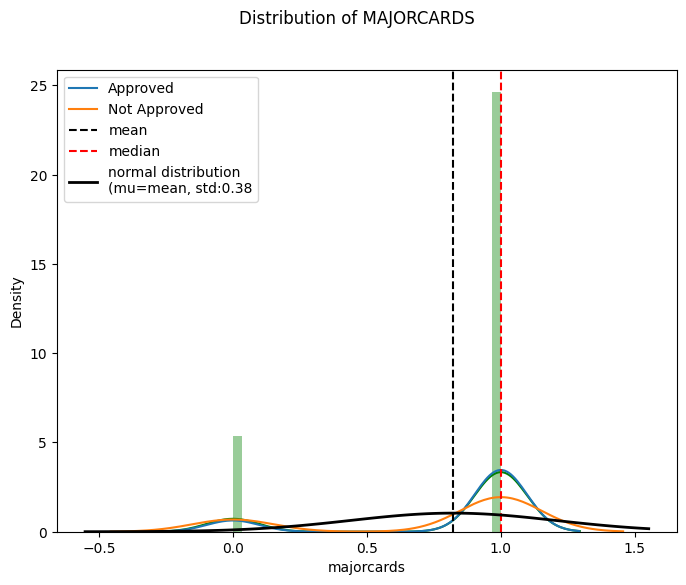

In [36]:
check_dist(numerical_columns[7])

Most applicants already have a credit card.

##### active

count    903.000000
mean       6.929125
std        6.391640
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       46.000000
Name: active, dtype: float64
Median: 5.0


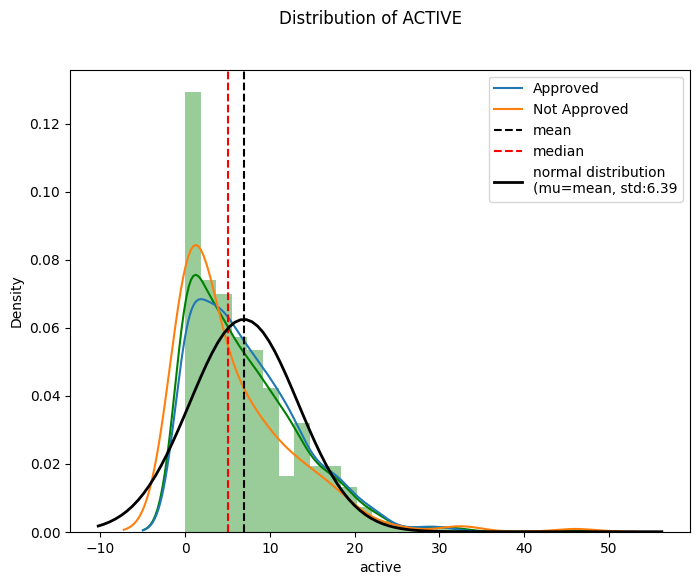

In [37]:
check_dist(numerical_columns[8])

Most applicants have no active credit accounts.

### Categorical Data Distribution.

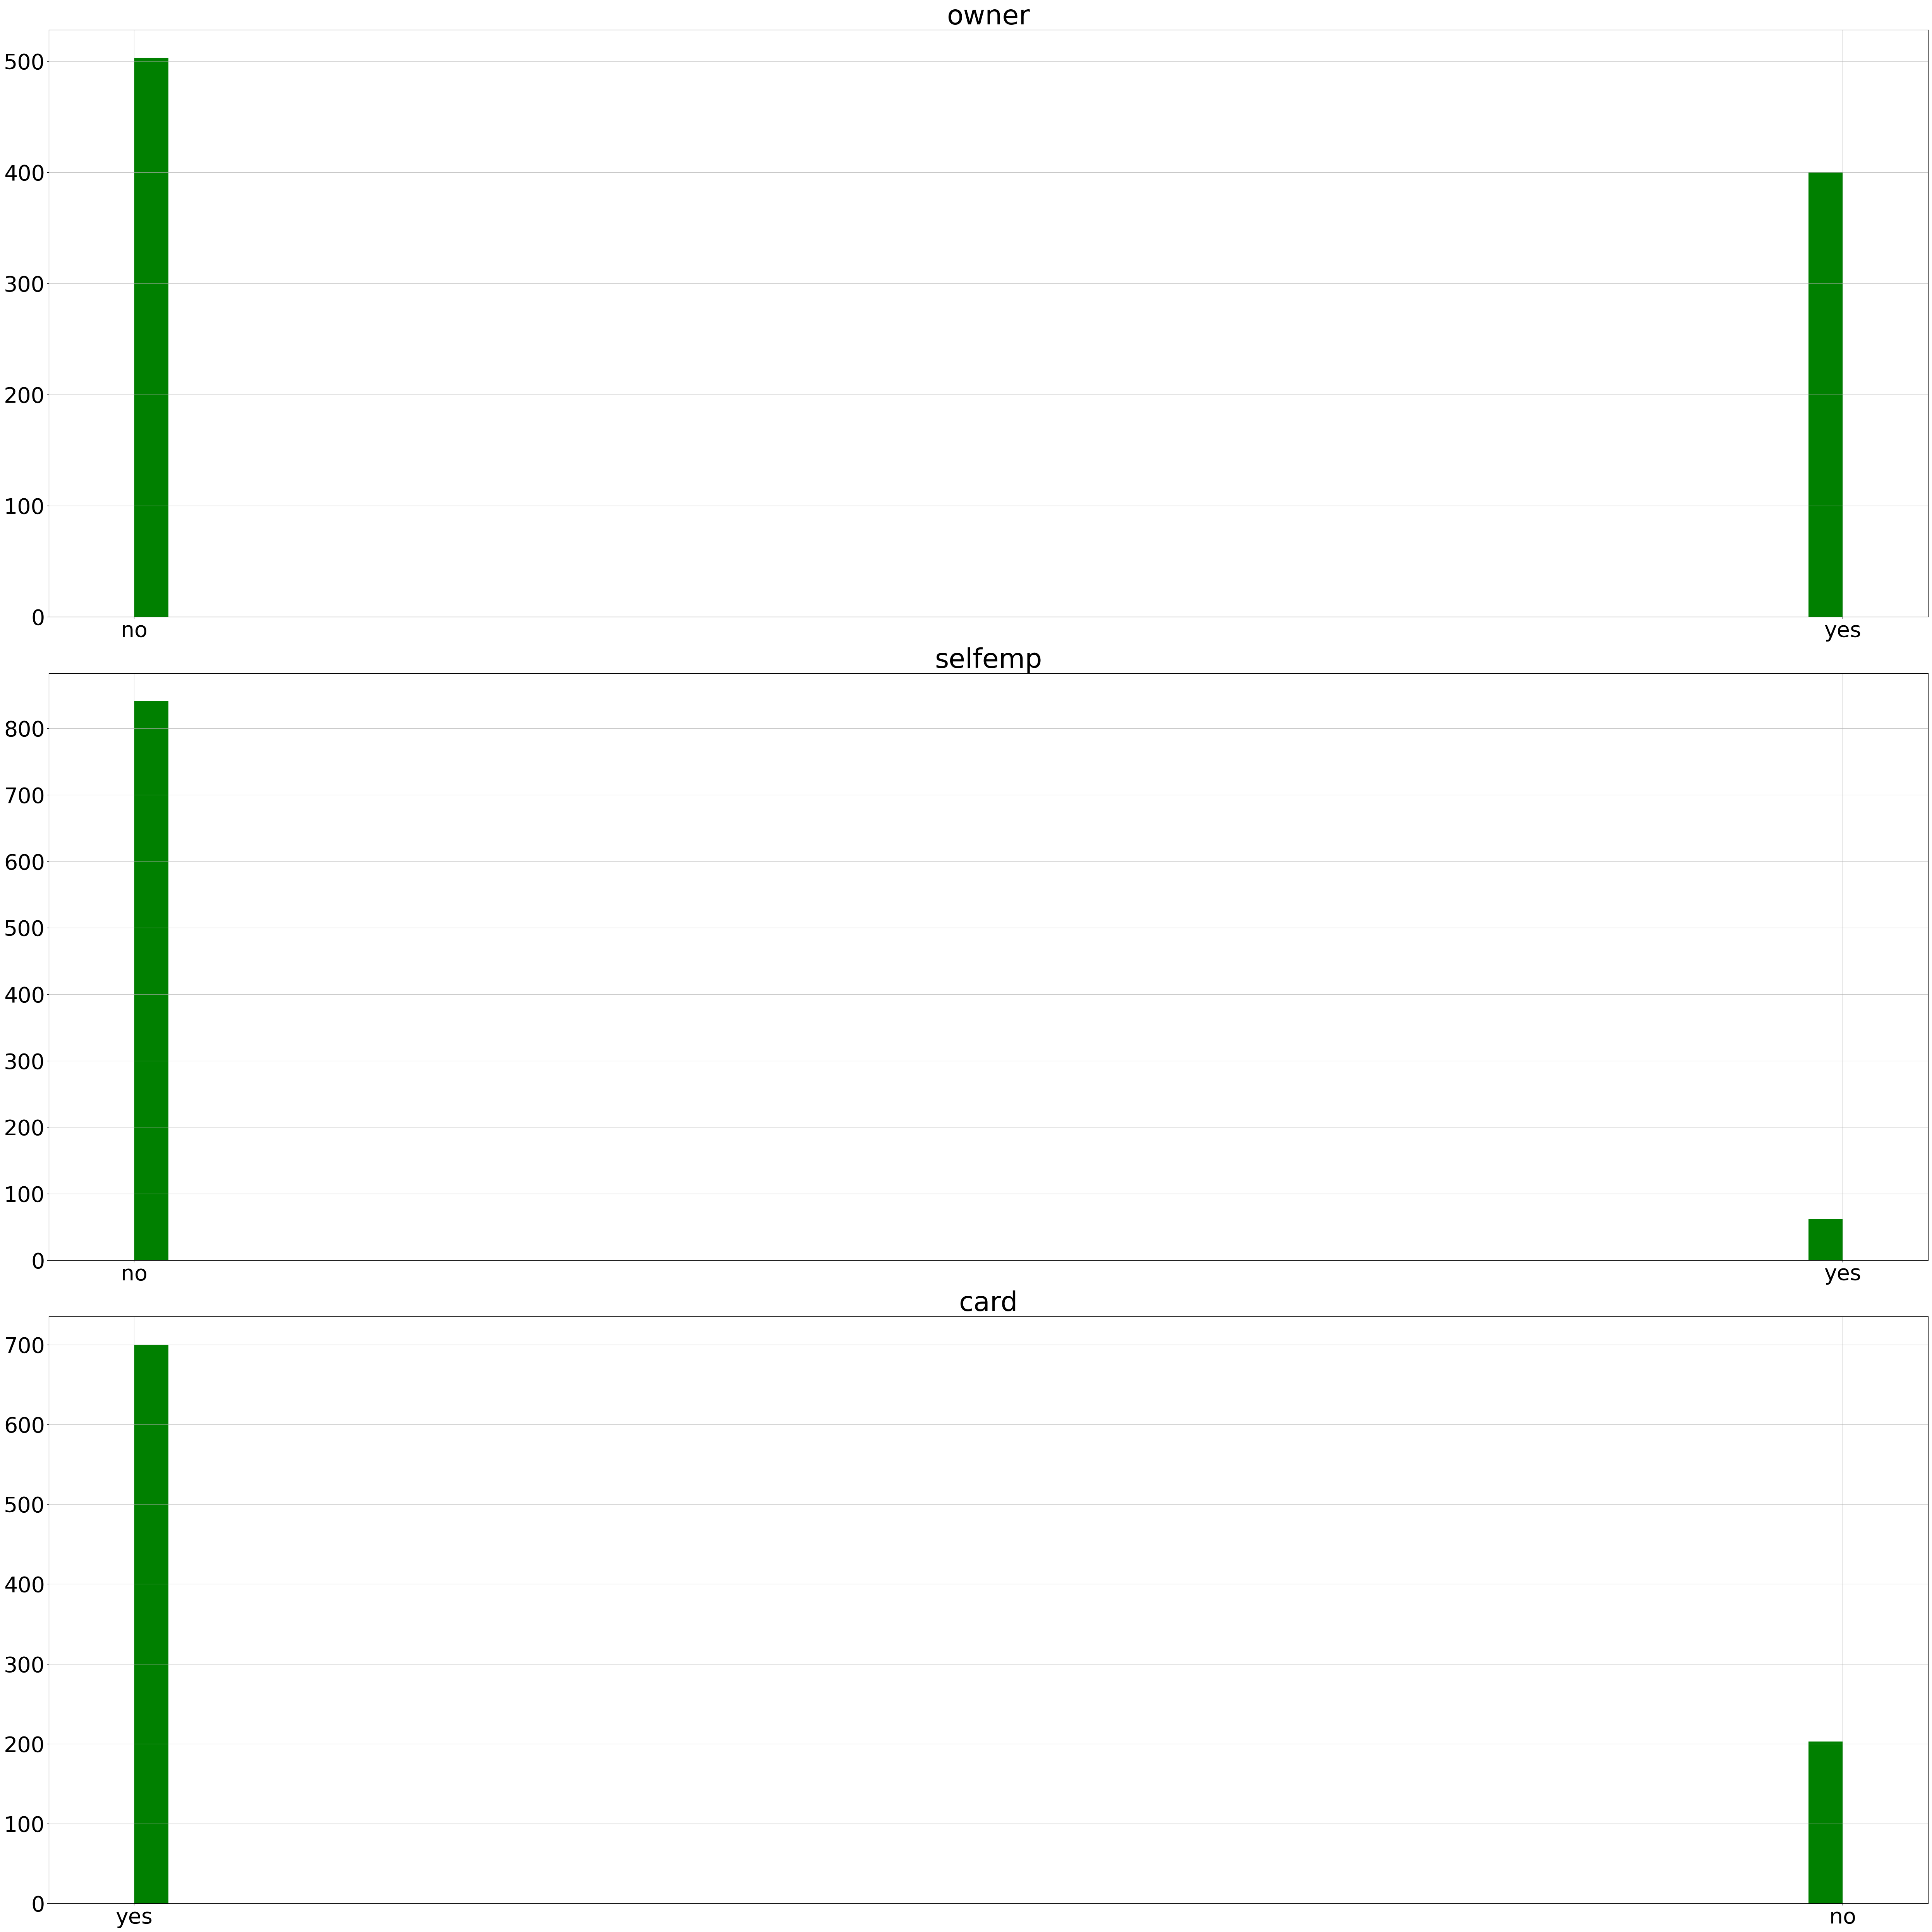

In [38]:
# Visualize the categorical data distribution
draw_histograms(EDA_df, categorical_columns, 3, 1, 50)

Next, I will analyze deeper into the categorical columns.

#### Detail EDA on each feature.

Since all categorical features are binary, so I will observe the distribution of each feature to the `card` feature.

##### owner

In [39]:
# Check the ditribution and percentage of `owner` feature
print(f"Applicants' home ownership distribution\n{EDA_df['owner'].value_counts()}")
print("-------------------------------------\n")
print(f"Applicants' home ownership percentage\n{EDA_df['owner'].value_counts(normalize = True)*100}")

Applicants' home ownership distribution
no     503
yes    400
Name: owner, dtype: int64
-------------------------------------

Applicants' home ownership percentage
no     55.703212
yes    44.296788
Name: owner, dtype: float64


The applicants whose not own a home are the majority.

##### selfemp

In [40]:
# Check the distribution and percentage of `owner` feature
print(f"Applicants' self-employment status distribution\n{EDA_df['selfemp'].value_counts()}")
print("-------------------------------------\n")
print(f"Applicants' self-employment status percentage\n{EDA_df['selfemp'].value_counts(normalize = True)*100}")

Applicants' self-employment status distribution
no     841
yes     62
Name: selfemp, dtype: int64
-------------------------------------

Applicants' self-employment status percentage
no     93.133998
yes     6.866002
Name: selfemp, dtype: float64


The self-employed applicants are the significant minority.

## Correlation

### Numerical Columns

<Axes: >

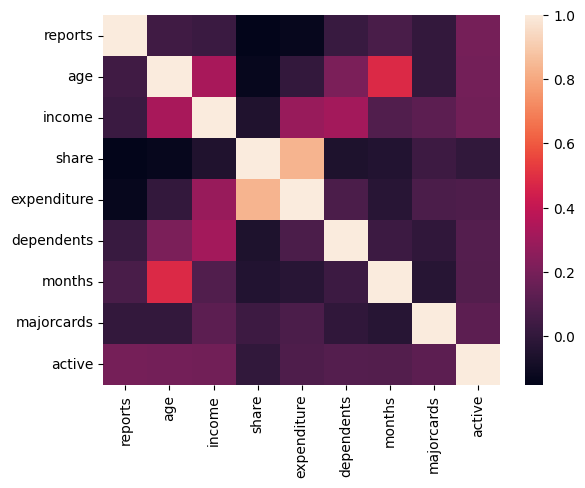

In [41]:
# print Pearson Correlation heatmap
sns.heatmap(EDA_df.corr(numeric_only = True))

The heatmap above shows the correlation between the numerical features, which from it can be concluded that the closely related features are just between `expenditure` and `share`.

Later in the Feature Engineering chapter, I will convert the `income` feature into a monthly value and multiply by 10,000 to get the real value to conform it with the features `expenditure` and `share`.

### Categorical Columns

#### owner vs card

In [42]:
CrosstabCount = pd.crosstab(index=EDA_df['owner'],\
                            columns=EDA_df['card'],\
                            margins = True, margins_name = "total")
print(f"Cross-tabulation of owner and card (count):\n \n{CrosstabCount}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['owner'],\
                           columns=EDA_df['card'],\
                           margins = True, margins_name = "total",\
                           normalize = True)*100
print(f"Cross-tabulation of owner and card (percentage):\n \n{CrosstabPerc}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['owner'],\
                           columns=EDA_df['card'],\
                           normalize = 'index')*100
print(f"Cross-tabulation of owner and card (relative percentage of owner):\n \n{CrosstabPerc}")

Cross-tabulation of owner and card (count):
 
card    no  yes  total
owner                 
no     144  359    503
yes     59  341    400
total  203  700    903
-------------------------------------

Cross-tabulation of owner and card (percentage):
 
card          no        yes       total
owner                                  
no     15.946844  39.756368   55.703212
yes     6.533776  37.763012   44.296788
total  22.480620  77.519380  100.000000
-------------------------------------

Cross-tabulation of owner and card (relative percentage of owner):
 
card          no        yes
owner                      
no     28.628231  71.371769
yes    14.750000  85.250000


The applicants whose not own a home are the majority, however the homeowners still have a higher probability to be approved.

#### selfemp vs card

In [43]:
CrosstabCount = pd.crosstab(index=EDA_df['selfemp'],\
                            columns=EDA_df['card'],\
                            margins = True, margins_name = "total")
print(f"Cross-tabulation of selfemp and card (count):\n \n{CrosstabCount}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['selfemp'],\
                           columns=EDA_df['card'],\
                           margins = True, margins_name = "total",\
                           normalize = True)*100
print(f"Cross-tabulation of selfemp and card (percentage):\n \n{CrosstabPerc}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['selfemp'],\
                           columns=EDA_df['card'],\
                           normalize = 'index')*100
print(f"Cross-tabulation of selfemp and card (relative percentage of selfemp):\n \n{CrosstabPerc}")

Cross-tabulation of selfemp and card (count):
 
card      no  yes  total
selfemp                 
no       183  658    841
yes       20   42     62
total    203  700    903
-------------------------------------

Cross-tabulation of selfemp and card (percentage):
 
card            no        yes       total
selfemp                                  
no       20.265781  72.868217   93.133998
yes       2.214839   4.651163    6.866002
total    22.480620  77.519380  100.000000
-------------------------------------

Cross-tabulation of selfemp and card (relative percentage of selfemp):
 
card            no        yes
selfemp                      
no       21.759810  78.240190
yes      32.258065  67.741935


The self-employed applicants are the significant minority, and their probability to be approved is not pretty high, this feature has a low correlation to the credit card approval decision.

## Conclusion



After the thorough data comprehension, I summarize some further works to be done in the next step (data preprocessing and feature engineering), which are:

+ Data transformation (log-transformation) on `income`, `expenditure`, and `months`.
+ Label Encoding on the categorical features.
+ Data binning on the feature `age`, `reports`, `dependents`, and `active`.
+ Conversion of the `income` data to the original value (multiply by 10,000) and divide it to a monthly value (divide by 12).
+ Category Balancing on the feature `card`.







# Data Preprocessing



Prepare the datasets.

In [44]:
# Rename the train dataset
df_train = utils.pkl_load(config["dataset_EDA_path"])
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

# Concatenate the x_valid and y_valid for preprocessing
x_valid = utils.pkl_load(config["dataset_valid_path"][0])
y_valid = utils.pkl_load(config["dataset_valid_path"][1])
df_valid = pd.concat([x_valid, y_valid], axis=1).reset_index(drop=True)
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

# Concatenate the x_test and y_test for preprocessing
x_test = utils.pkl_load(config["dataset_test_path"][0])
y_test = utils.pkl_load(config["dataset_test_path"][1])
df_test = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

## Data Transformation

For the data with an extensive range, I will transform them to squeeze the range so the distribution will get near to a normal distribution than a skewed one.

The features that need to be transformed are: `income`, `expenditure`, and `months`.

In [45]:
# Group of features to be transformed
config["cols_to_log"]

['income', 'expenditure', 'months']

In [46]:
# Create the function for data transformation
def cols_transform(dataset):
    """A function to transform the feature(s) value in the dataset into logarithmic value.
    The defined features are transformed and appended to the dataset,
    after the transformation and appendment of all features are done
    the features with original value are dropped from the dataset"""

    log_cols = []
    for i in range (len(config["cols_to_log"])):
        col = config["cols_to_log"][i]
        transformed = col + "_log" 
        dataset[transformed] = np.log10(dataset[col]+1)
        
        log_cols.append(transformed)
    dataset.drop(config["cols_to_log"], axis = 1, inplace = True)
    return dataset

### Training Data

The histogram plots before transformation


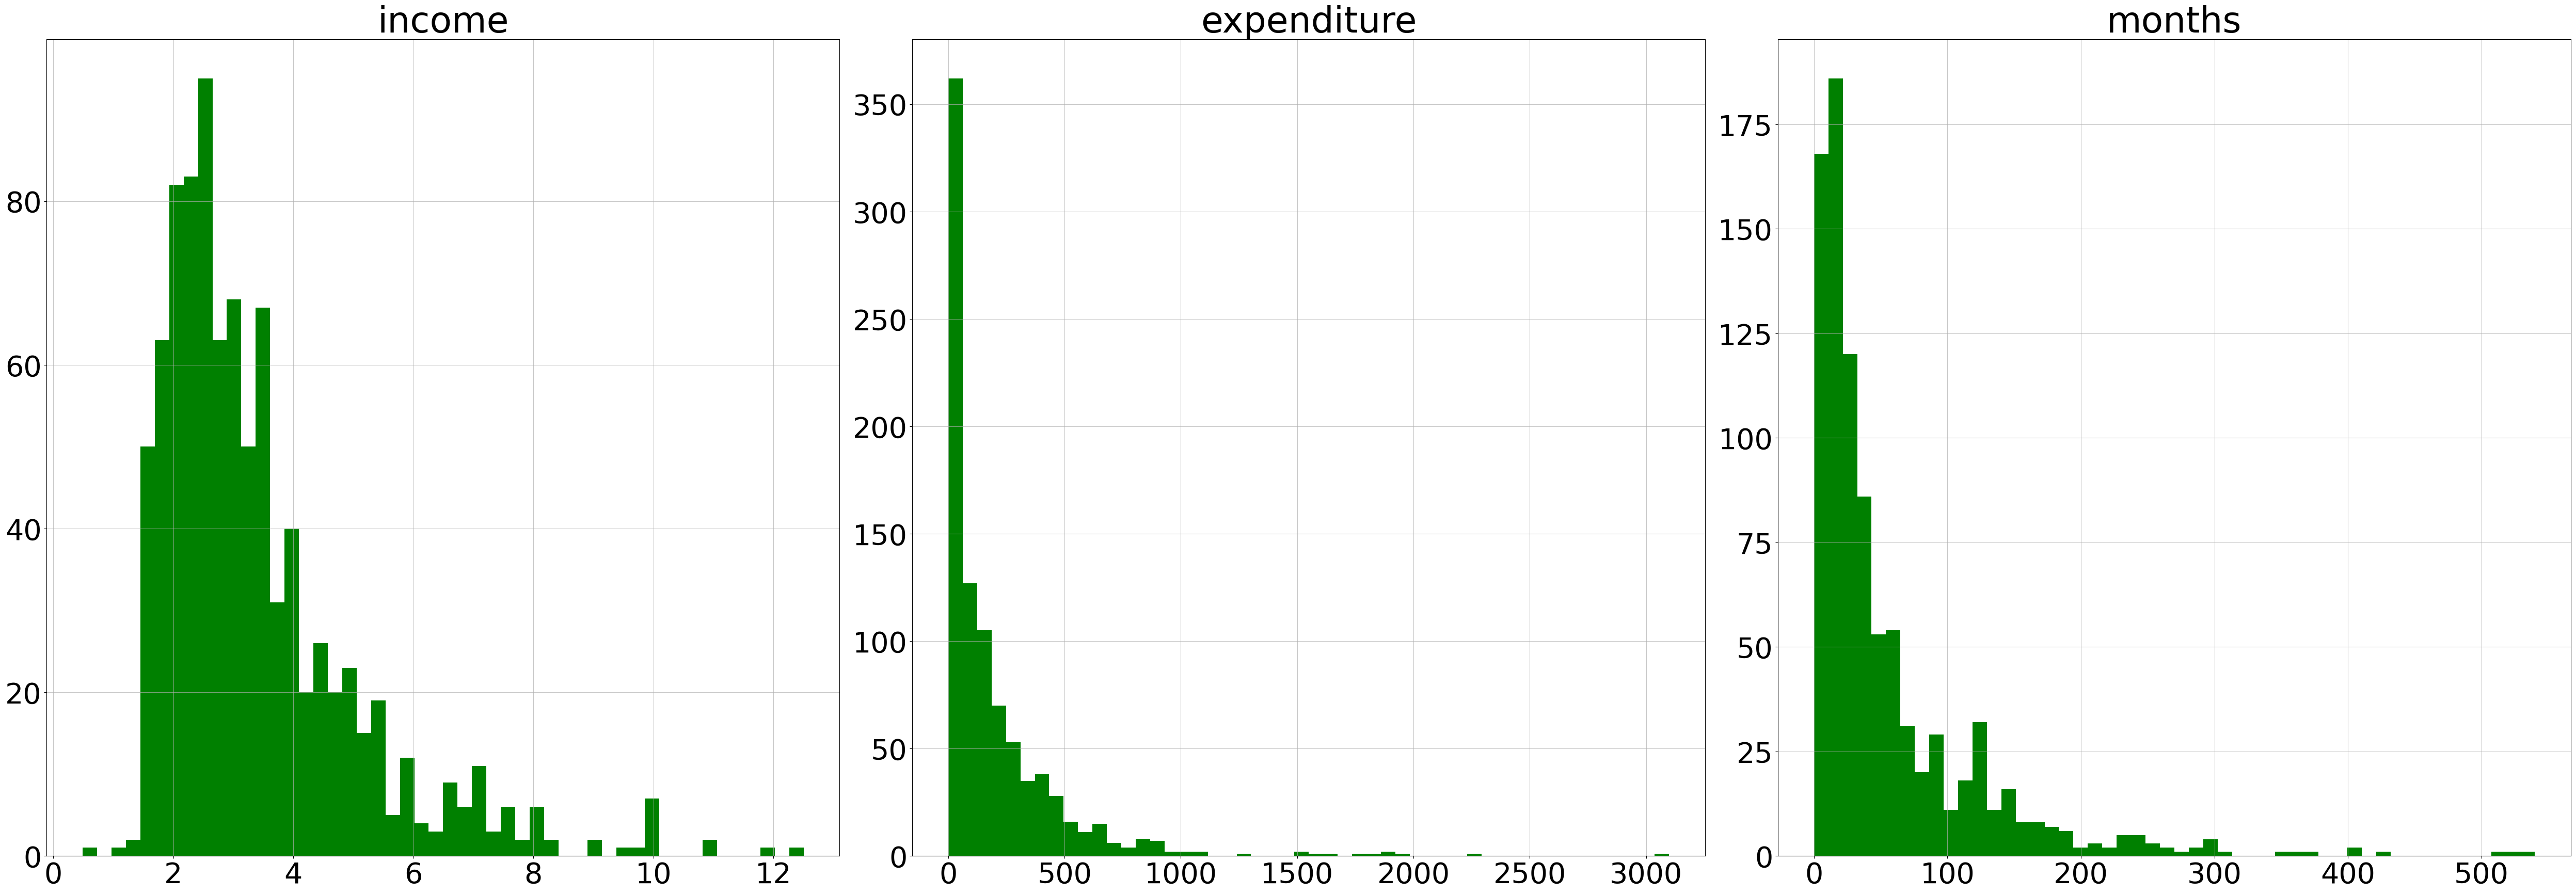

In [47]:
print("The histogram plots before transformation")
draw_histograms(df_train, config["cols_to_log"], 3, 3, 50)

In [48]:
# Execute the transformation function
df_train = cols_transform(df_train)

In [49]:
# Recheck the dataframe columns after transformation
df_train.columns

Index(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'card', 'income_log', 'expenditure_log',
       'months_log'],
      dtype='object')

In [50]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

The histogram plots of the transformed features


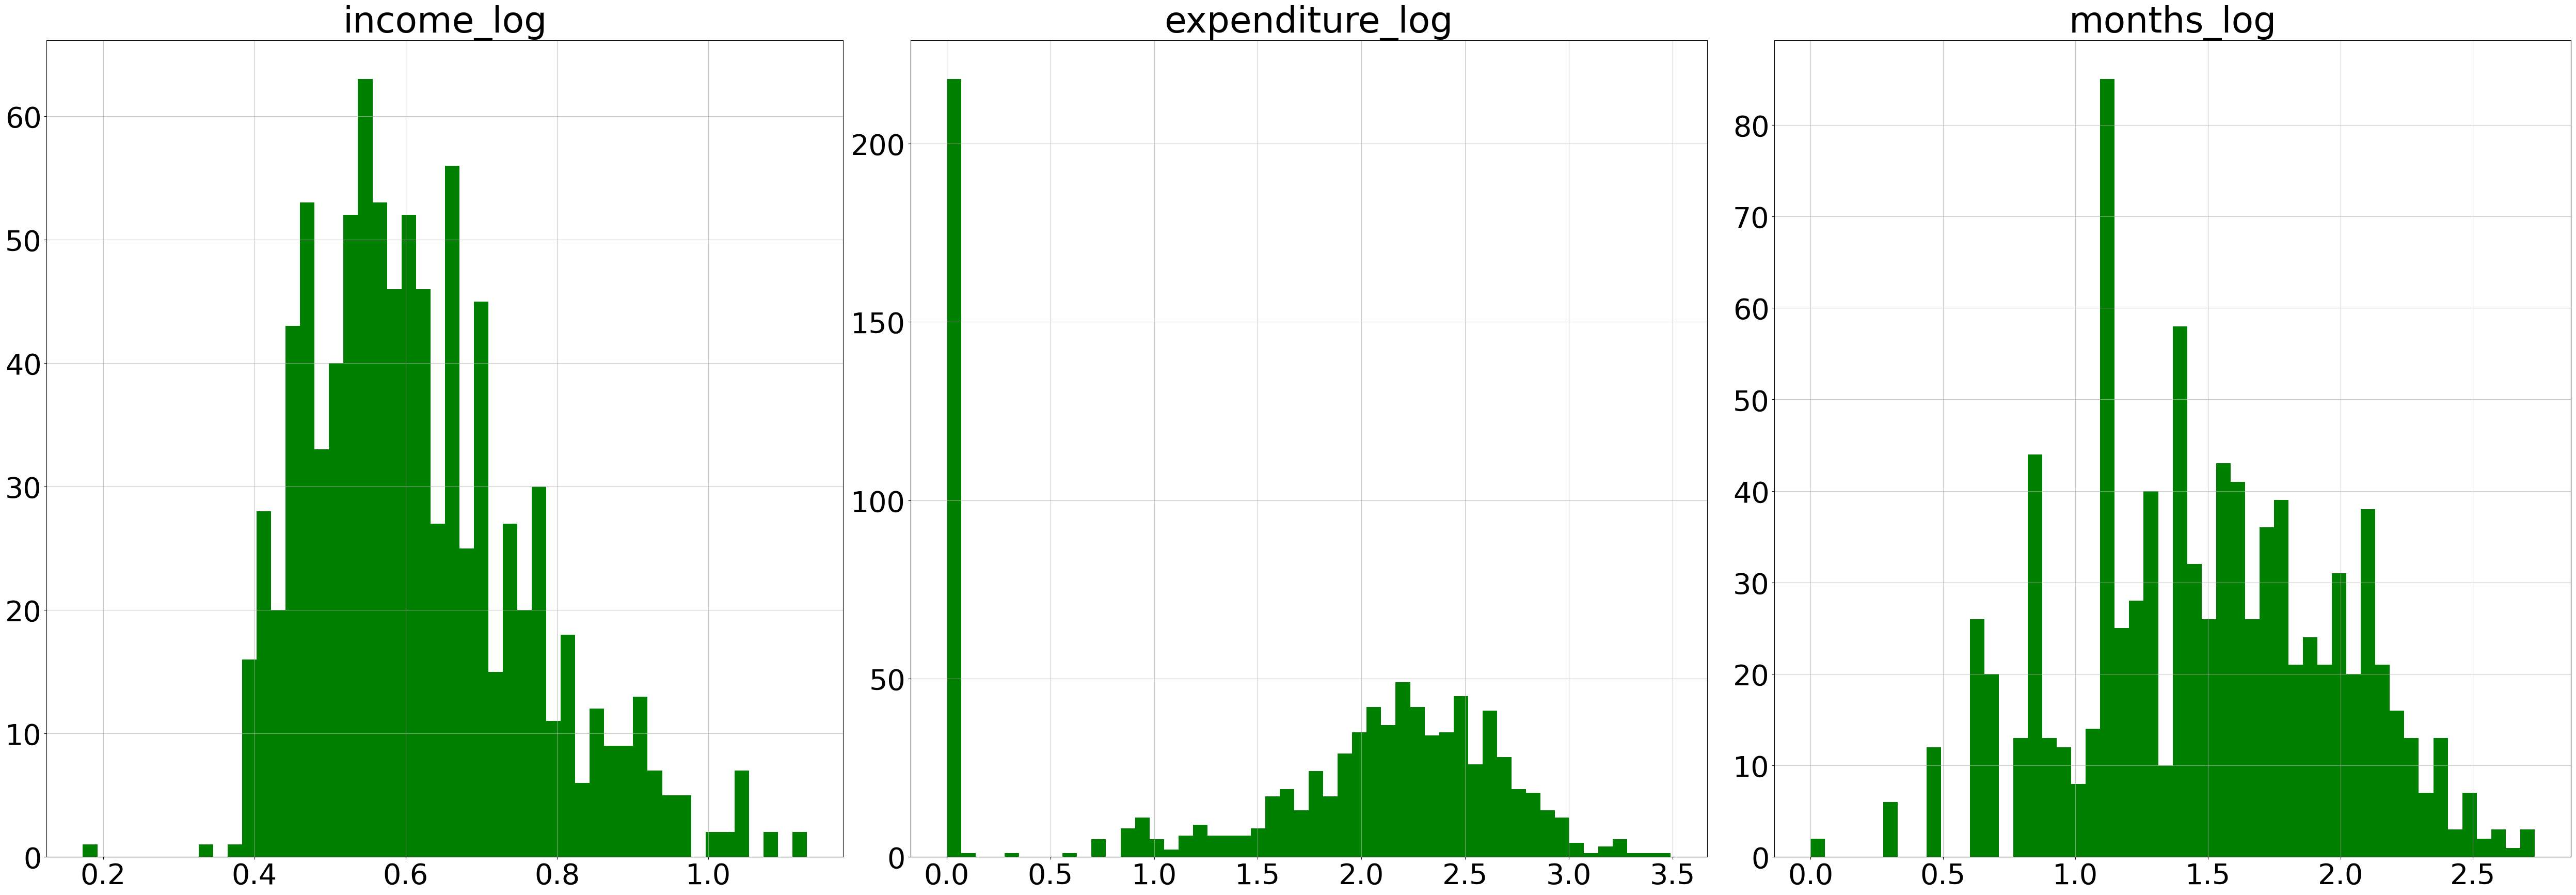

In [51]:
print("The histogram plots of the transformed features")
draw_histograms(df_train, config['log_cols'], 3, 3, 50)

### Validation Data

The histogram plots before transformation


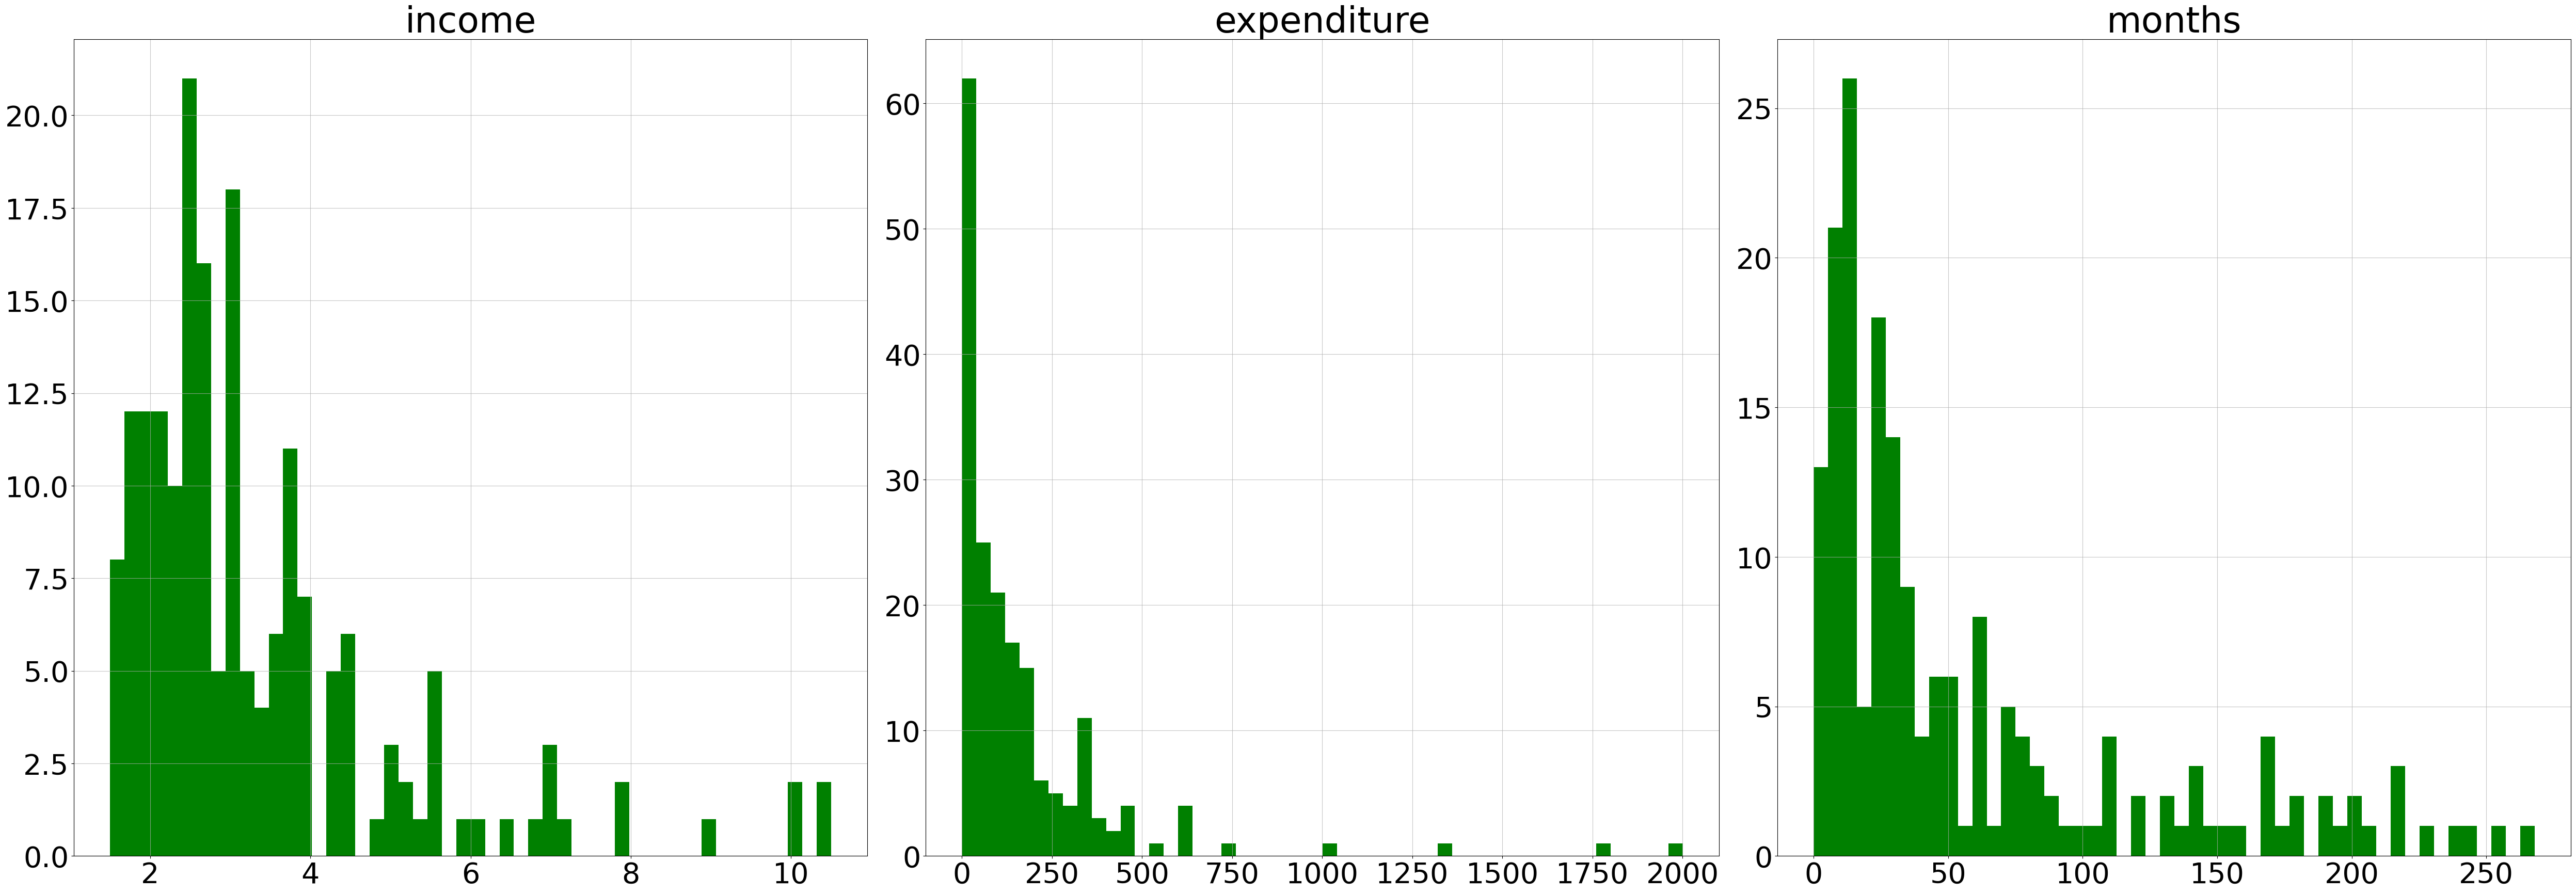

In [52]:
print("The histogram plots before transformation")
draw_histograms(df_valid, config["cols_to_log"], 3, 3, 50)

In [53]:
# Execute the transformation function
df_valid = cols_transform(df_valid)

In [54]:
# Recheck the dataframe columns after transformation
df_valid.columns

Index(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'card', 'income_log', 'expenditure_log',
       'months_log'],
      dtype='object')

In [55]:
# Save as pickle file
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

The histogram plots of the transformed features


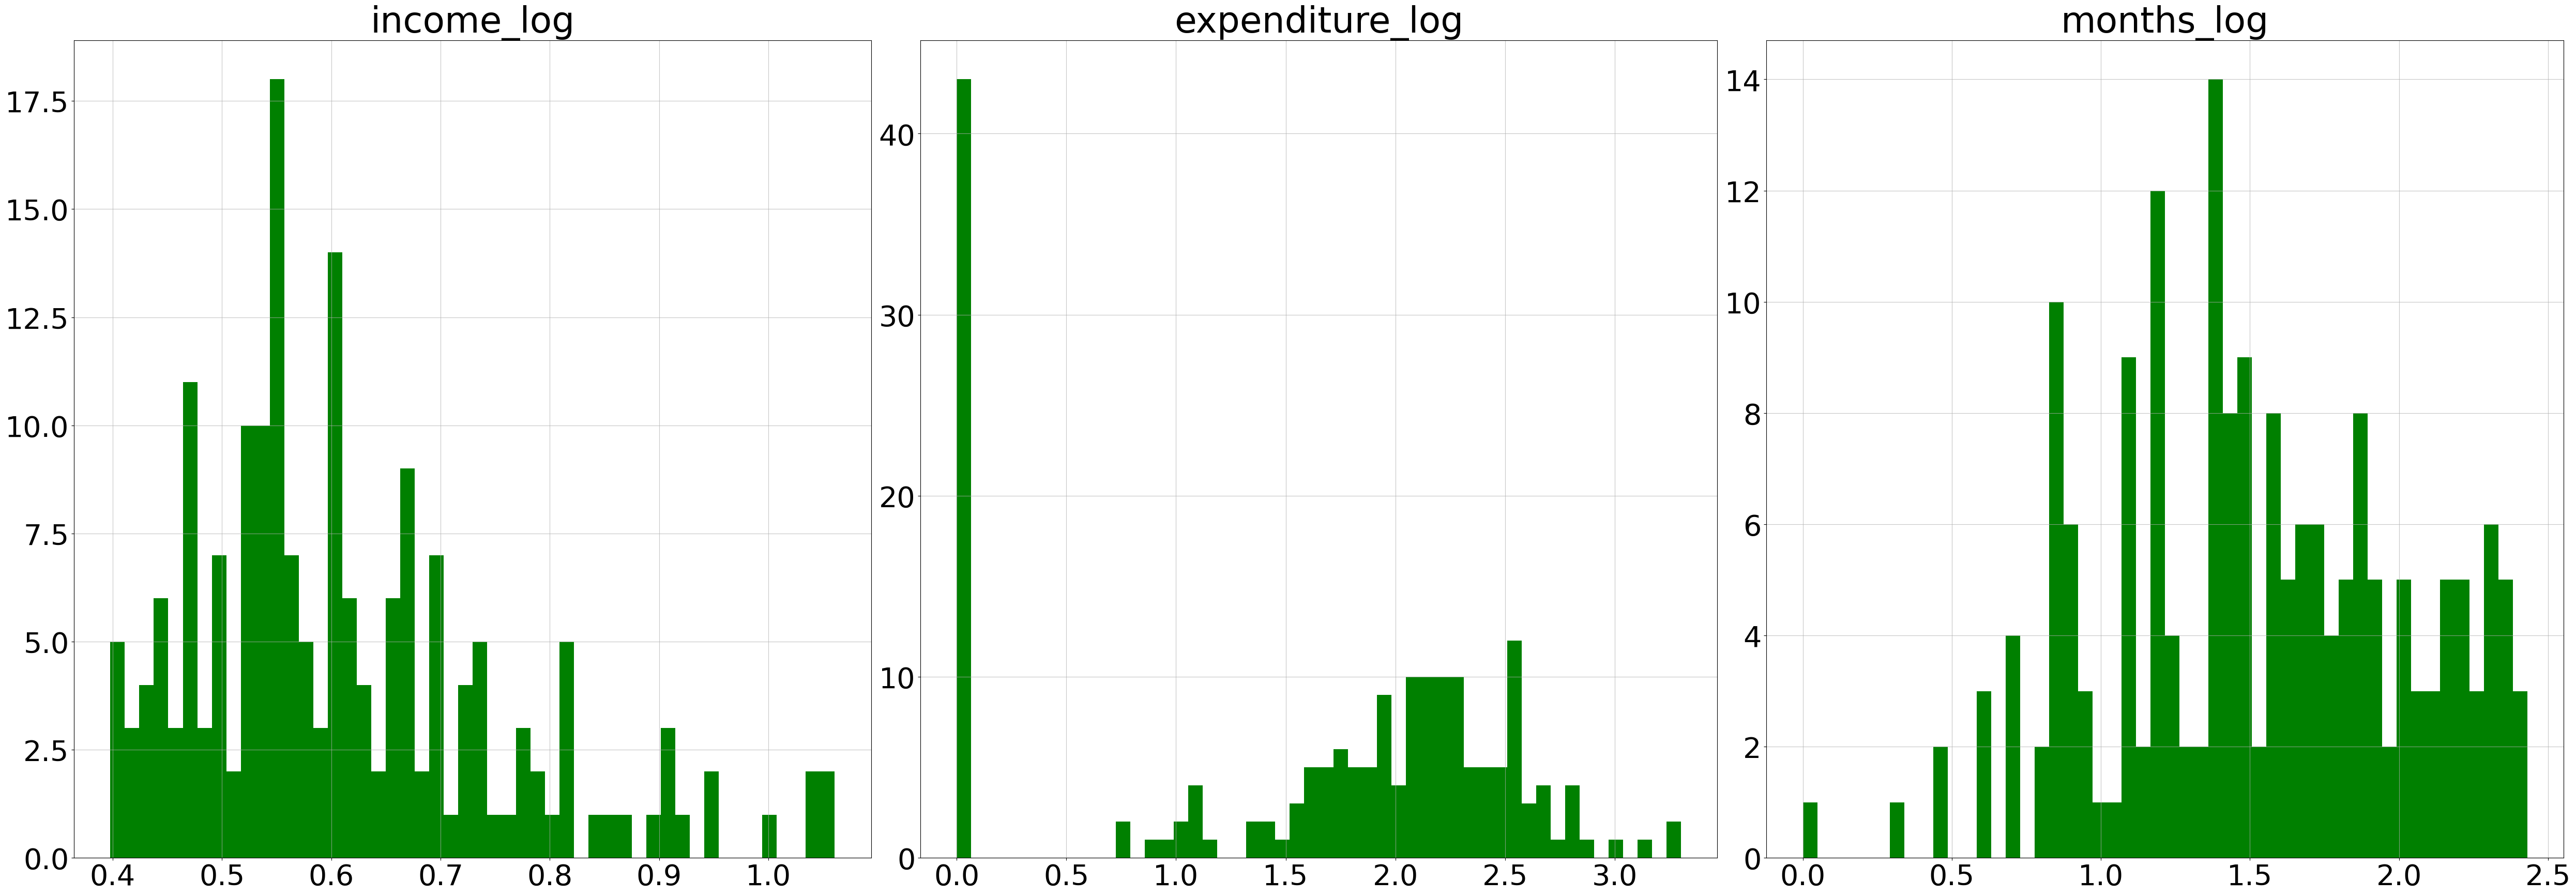

In [56]:
print("The histogram plots of the transformed features")
draw_histograms(df_valid, config['log_cols'], 3, 3, 50)

### Testing Data

The histogram plots before transformation


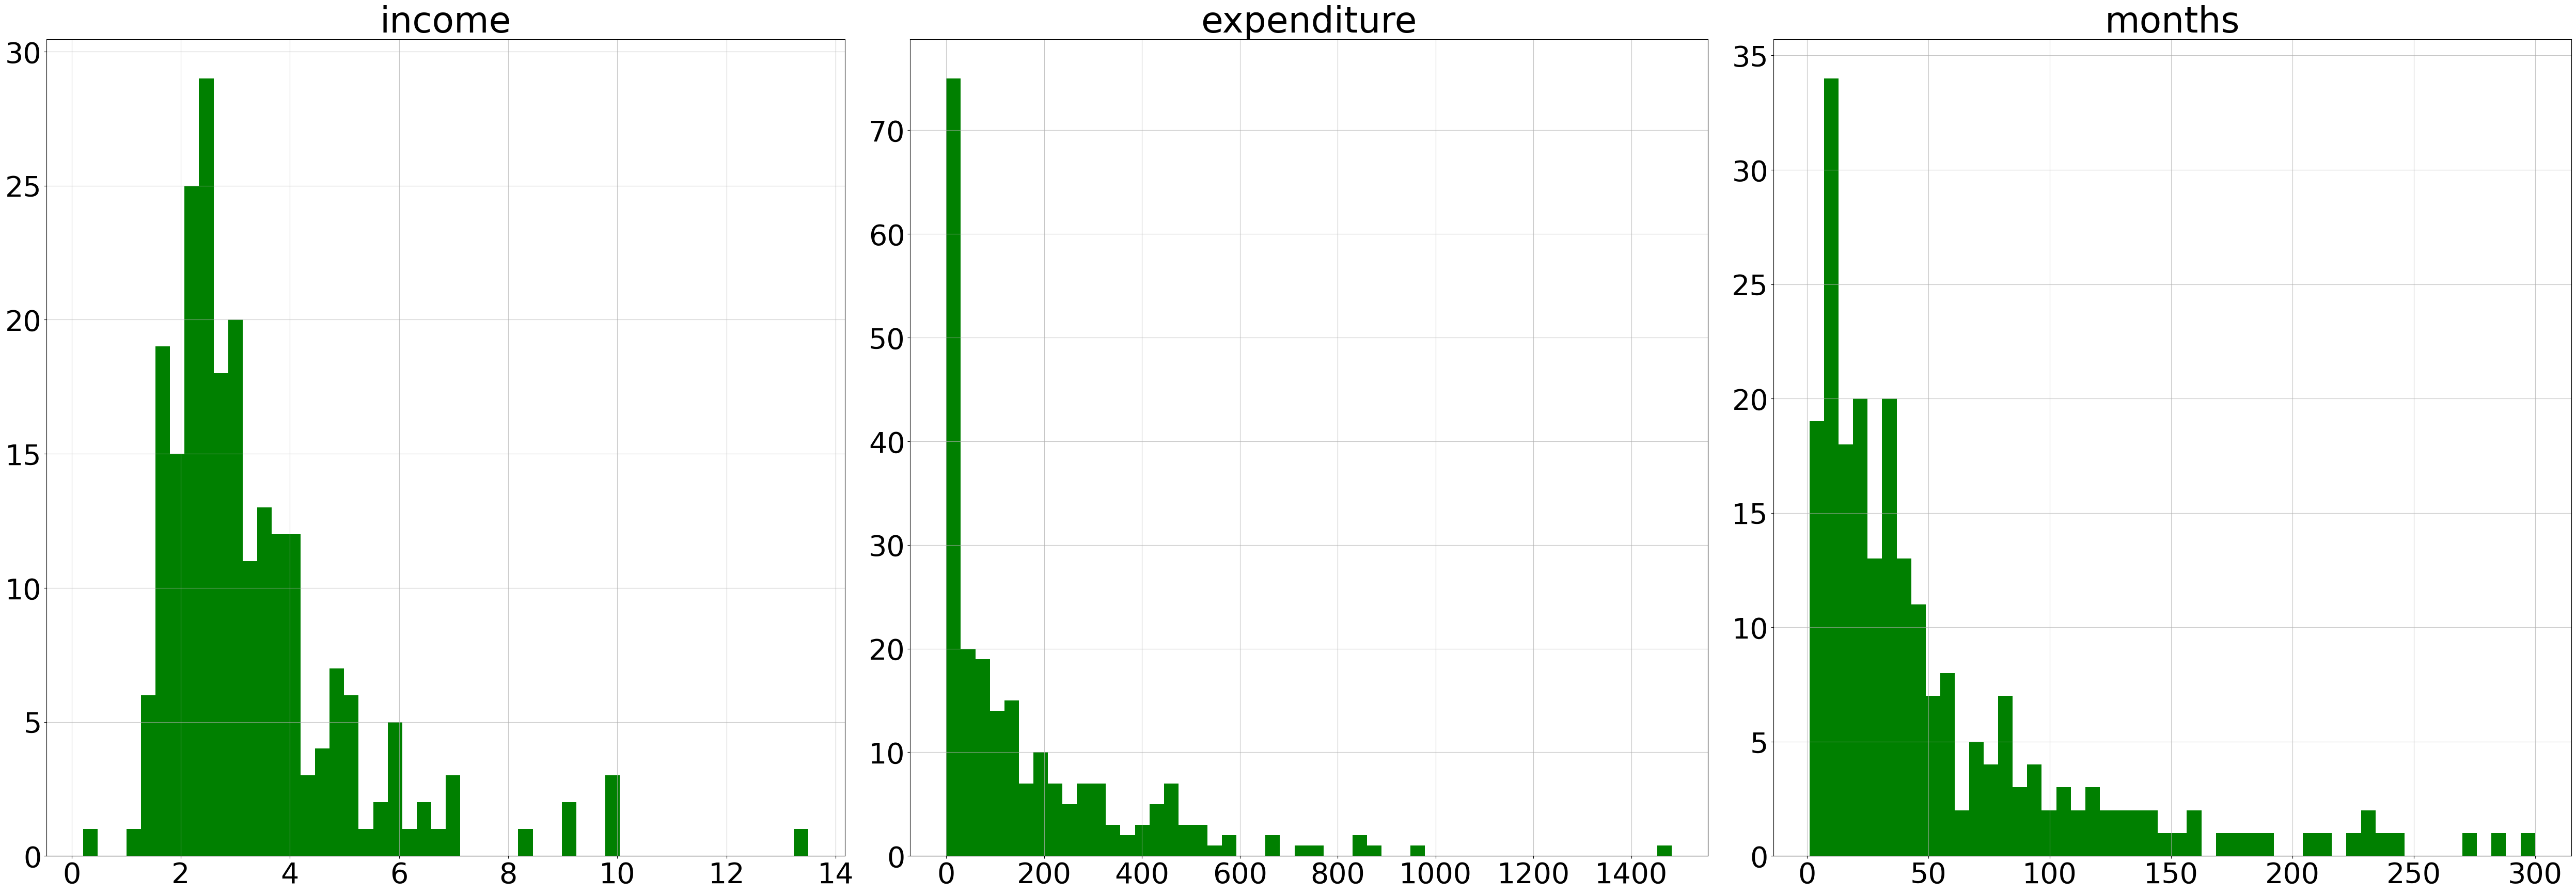

In [57]:
print("The histogram plots before transformation")
draw_histograms(df_test, config["cols_to_log"], 3, 3, 50)

In [58]:
# Execute the transformation function
df_test = cols_transform(df_test)

In [59]:
# Recheck the dataframe columns after transformation
df_test.columns

Index(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'card', 'income_log', 'expenditure_log',
       'months_log'],
      dtype='object')

In [60]:
# Save as pickle file
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

The histogram plots of the transformed features


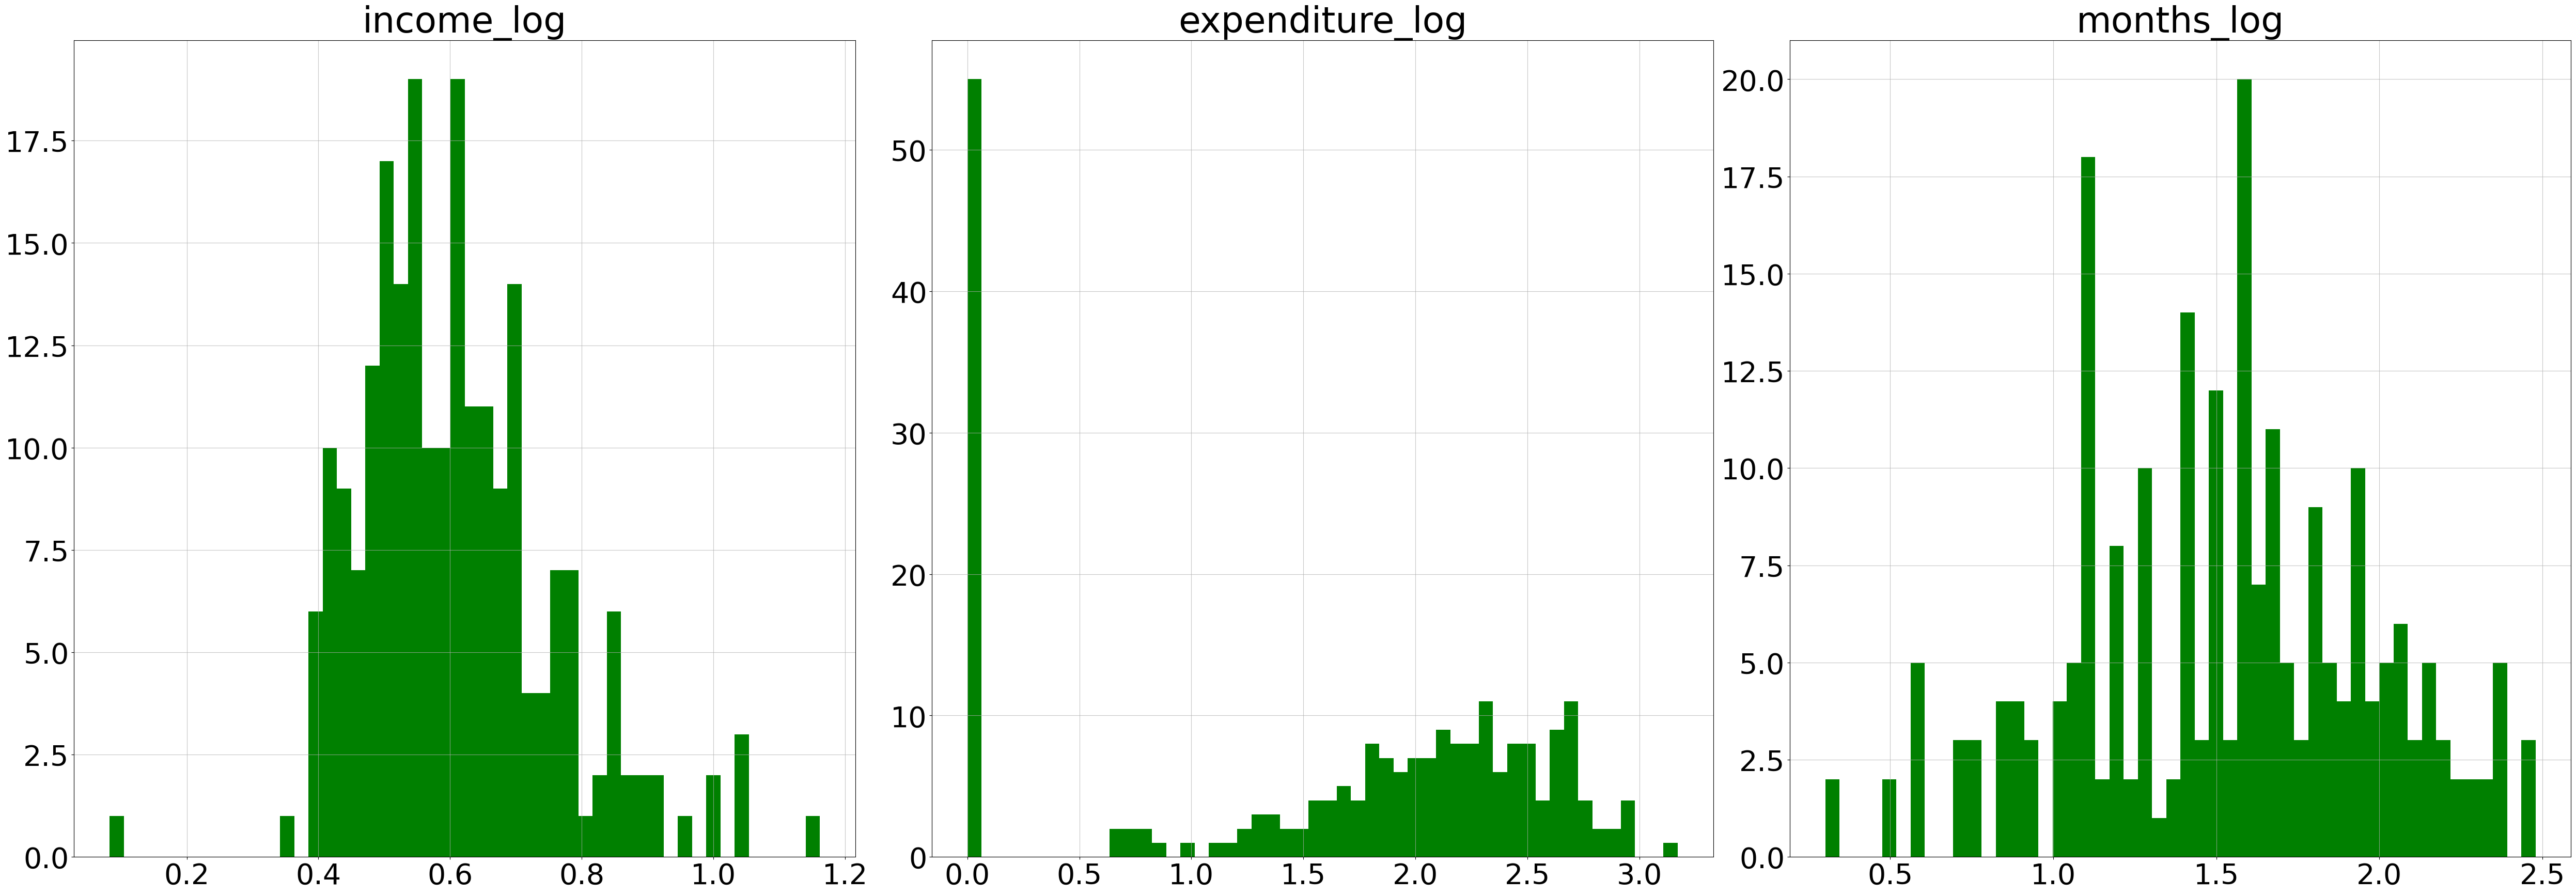

In [61]:
print("The histogram plots of the transformed features")
draw_histograms(df_test, config['log_cols'], 3, 3, 50)

## Label Encoding

Convert the values of categorical features into numeric ones.

The features are: `owner`, `selfemp`, and `card`.

The encoded result value are 0 (zero) for "no", and 1 for "yes".

Let's first check the columns:

In [62]:
categorical_columns = config["cat_columns"]
print(f"The Original Categorical Columns:\n{df_train[categorical_columns].tail()}\n")
print("-------------------------------------\n")
df_train[categorical_columns].info()


The Original Categorical Columns:
    owner selfemp card
898    no      no  yes
899    no      no   no
900    no      no  yes
901   yes     yes  yes
902   yes      no   no

-------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   owner    903 non-null    object
 1   selfemp  903 non-null    object
 2   card     903 non-null    object
dtypes: object(3)
memory usage: 21.3+ KB


In [63]:
# Create function to encode the categorical columns
def label_encoding(dataset):
    """A function to convert the categorical values into the numeric ones.
    The list of categorical features are encoded by .map function,
    returning a dataset with the features encoded."""
    for i in range (len(config["cat_columns"])):
        col = config["cat_columns"][i]
        dataset[col] = dataset[col].map({'yes':1, 'no':0})
    return dataset

### Training Data

In [64]:
# Execute the label encoding function
df_train = label_encoding(df_train)

In [65]:
print(f"The Encoded Categorical Columns:\n{df_train[categorical_columns].tail()}\n")

df_train[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
898      0        0     1
899      0        0     0
900      0        0     1
901      1        1     1
902      1        0     0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    903 non-null    int64
 1   selfemp  903 non-null    int64
 2   card     903 non-null    int64
dtypes: int64(3)
memory usage: 21.3 KB


In [66]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

### Validation Data

In [67]:
# Execute the label encoding function
df_valid = label_encoding(df_valid)

In [68]:
print(f"The Encoded Categorical Columns:\n{df_valid[categorical_columns].tail()}\n")

df_valid[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
180      1        0     1
181      0        0     1
182      0        0     1
183      0        0     0
184      0        0     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    185 non-null    int64
 1   selfemp  185 non-null    int64
 2   card     185 non-null    int64
dtypes: int64(3)
memory usage: 4.5 KB


In [69]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][1])

### Testing Data

In [70]:
# Execute the label encoding function
df_test = label_encoding(df_test)

In [71]:
print(f"The Encoded Categorical Columns:\n{df_test[categorical_columns].tail()}\n")

df_test[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
219      0        0     1
220      1        1     1
221      1        0     1
222      1        0     1
223      0        0     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    224 non-null    int64
 1   selfemp  224 non-null    int64
 2   card     224 non-null    int64
dtypes: int64(3)
memory usage: 5.4 KB


In [72]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][2])

## Data Binning

The data binning process is useful to smoothen the data, it replaces values contained into a small interval with a single representative value for that interval, in order to improves the model accuracy.




In [73]:
# Create the function for data binning
def binning(dataset, col, bins, labels):
    """A function for categorize the feature's value in the col parameter into groups with specific interval defined in the bins parameter.
    Creates a new feature contains the value defined in the labels parameter."""
    
    binned = col +"_bin"
    dataset[binned] = pd.cut(dataset[col] , bins=bins, labels=labels, include_lowest=True).astype(int)
    return dataset

The features that suitable to be binned are: `age`, `reports`, `dependents`, and `active`.

### `age`

The age groups are divide based on the classification from FICO, source: [Age group for credit scoring](https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/)

The category definition of this feature are:
+ 1: 18 - 24 years old
+ 2: 25 - 40 years old
+ 3: 41 - 56 years old
+ 4: 57 - 75 years old
+ 5: more than 75 years old 

In [74]:
# Create the instance for the value boundary for each category
bins = [18, 24, 40, 56, 75, 99]

# Create the instance for age category labels
labels = [1, 2, 3, 4, 5]

#### Training Data

count    903.000000
mean      33.228313
std        9.955114
min       18.166670
25%       25.250000
50%       31.500000
75%       38.916670
max       83.500000
Name: age, dtype: float64
Median: 31.5


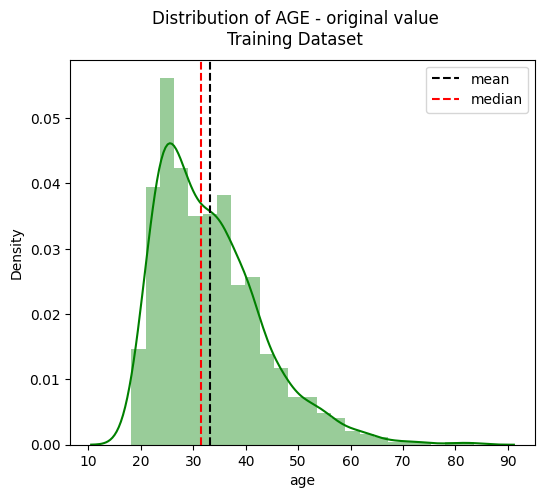

In [75]:
# Print the statistical information and histogram plot before data binning
x = df_train['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [76]:
# Execute the binning function
df_train = binning(df_train, 'age', config["bins_age"], config["labels_age"])

# Check the binning result and compare it with the original `age` value
df_train[['age', 'age_bin']].tail(10)

,age,age_bin
893,25.25000,2
894,26.08333,2
895,45.58333,3
896,32.58333,2
897,29.50000,2
898,35.83333,2
899,29.16667,2
900,29.41667,2
901,61.08333,4
902,27.33333,2


count    903.000000
mean       2.077519
std        0.697297
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: age_bin, dtype: float64
Median: 2.0


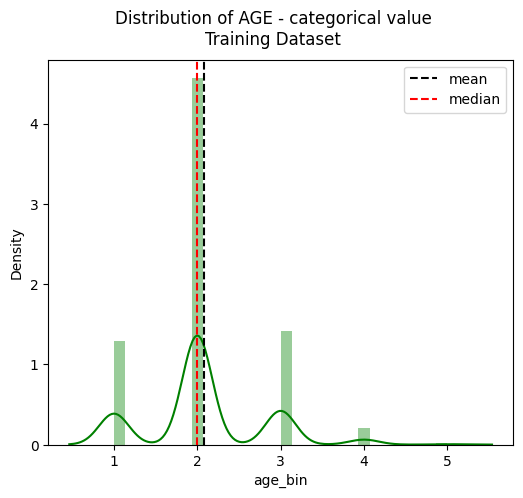

In [77]:
# Print the statistical information and histogram plot after data binning
x = df_train['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [78]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean      34.045946
std        9.915162
min       19.166670
25%       25.833330
50%       31.500000
75%       40.750000
max       65.916660
Name: age, dtype: float64
Median: 31.5


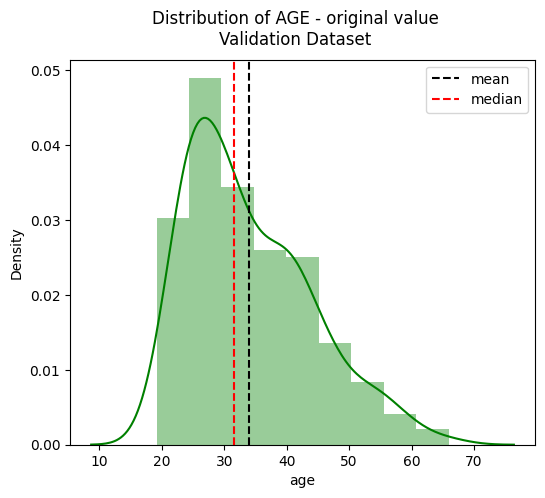

In [79]:
# Print the statistical information and histogram plot before data binning
  
x = df_valid['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [80]:
# Execute the binning function
df_valid = binning(df_valid, 'age', config["bins_age"], config["labels_age"])

# Check the binning result and compare it with the original `age` value
df_valid[['age', 'age_bin']].tail(10)

,age,age_bin
175,25.91667,2
176,28.50000,2
177,23.33333,1
178,54.41667,3
179,39.33333,2
180,43.83333,3
181,26.58333,2
182,26.66667,2
183,25.91667,2
184,23.83333,1


count    185.000000
mean       2.172973
std        0.685505
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: age_bin, dtype: float64
Median: 2.0


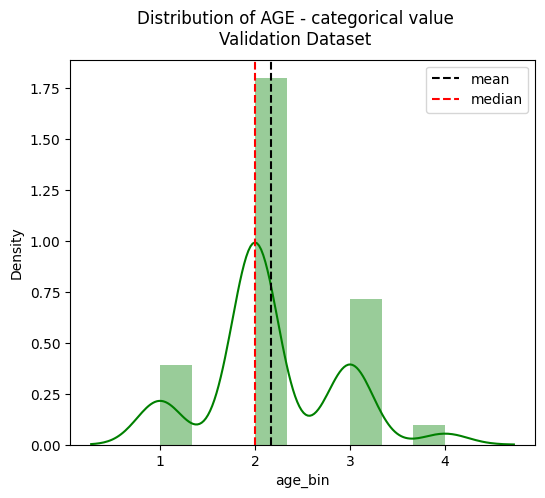

In [81]:
# Print the statistical information and histogram plot after data binning
x = df_valid['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [82]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

count    224.000000
mean      33.484747
std        9.586733
min       19.000000
25%       26.062497
50%       30.666665
75%       40.020832
max       63.750000
Name: age, dtype: float64
Median: 30.666665000000002


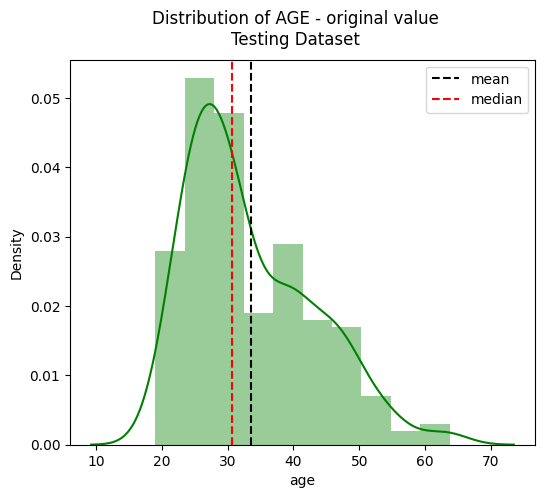

In [83]:
# Print the statistical information and histogram plot before data binning
  
x = df_test['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [84]:
# Execute the binning function
df_test = binning(df_test, 'age', config["bins_age"], config["labels_age"])

# Check the binning result and compare it with the original `age` value
df_test[['age', 'age_bin']].tail(10)

,age,age_bin
214,38.75000,2
215,63.41667,4
216,23.25000,1
217,25.25000,2
218,24.58333,2
219,62.50000,4
220,44.08333,3
221,31.33333,2
222,47.00000,3
223,26.08333,2


count    224.000000
mean       2.133929
std        0.649188
min        1.000000
25%        2.000000
50%        2.000000
75%        2.250000
max        4.000000
Name: age_bin, dtype: float64
Median: 2.0


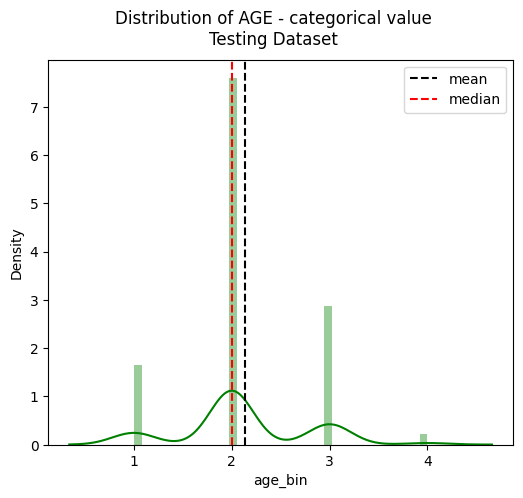

In [85]:
# Print the statistical information and histogram plot after data binning
x = df_test['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [86]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

### `reports`

The category definition of this feature are:
+ 0: zero major derogatory report, "clean record"
+ 1: 1 - 2 major derogatory reports
+ 2: 3 or more major derogatory report, "bad record"

In [87]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 2, 14]

# Create the instance for `reports` category labels
labels = [0, 1, 2]

#### Training Data

count    903.000000
mean       0.449612
std        1.396645
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       14.000000
Name: reports, dtype: float64
Median: 0.0


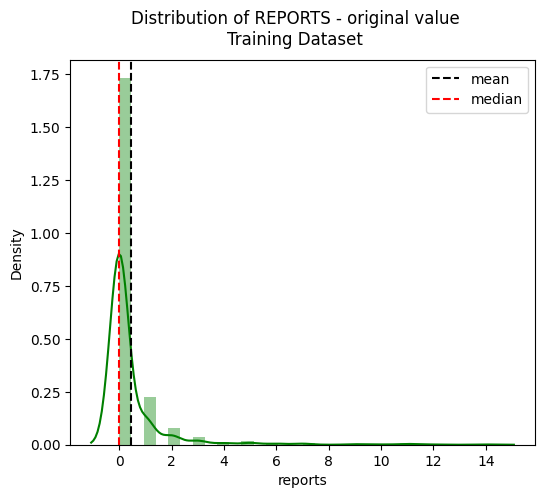

In [88]:
# Print the statistical information and histogram plot before data binning
x = df_train['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [89]:
# Execute the binning function
df_train = binning(df_train, 'reports', config["bins_reports"], config["labels_reports"])

# Check the binning result and compare it with the original `reports` value
df_train[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
893,0,0
894,0,0
895,0,0
896,2,1
897,7,2
898,0,0
899,0,0
900,0,0
901,0,0
902,3,2


count    903.000000
mean       0.240310
std        0.529457
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


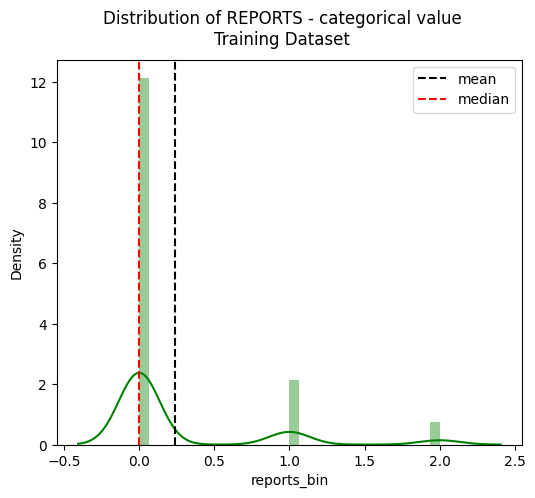

In [90]:
# Print the statistical information and histogram plot after data binning
x = df_train['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [91]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean       0.394595
std        1.037856
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.000000
Name: reports, dtype: float64
Median: 0.0


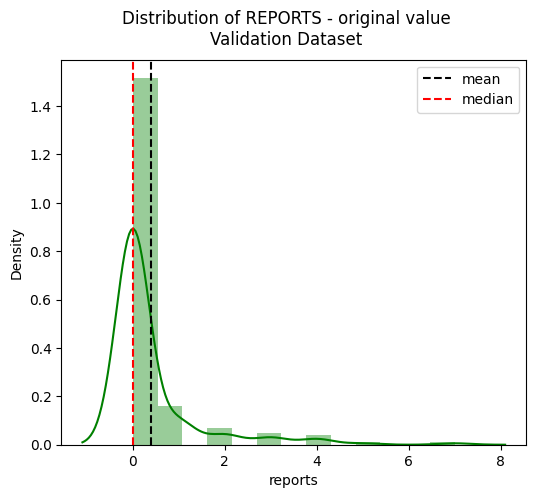

In [92]:
# Print the statistical information and histogram plot before data binning
x = df_valid['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [93]:
# Execute the binning function
df_valid = binning(df_valid, 'reports', config["bins_reports"], config["labels_reports"])

# Check the binning result and compare it with the original `reports` value
df_valid[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
175,0,0
176,1,1
177,0,0
178,0,0
179,0,0
180,0,0
181,2,1
182,0,0
183,2,1
184,0,0


count    185.000000
mean       0.243243
std        0.551943
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


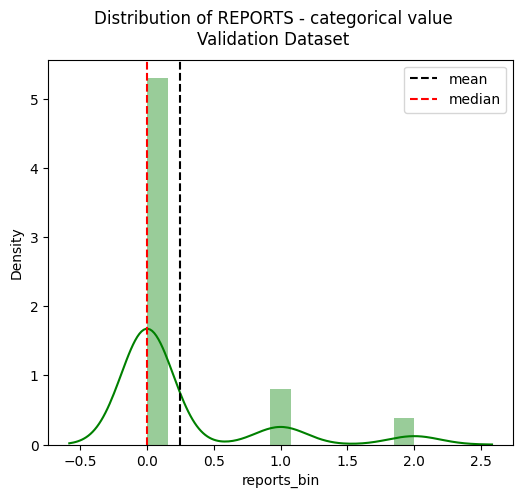

In [94]:
# Print the statistical information and histogram plot after data binning
x = df_valid['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [95]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

count    224.000000
mean       0.544643
std        1.378167
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       11.000000
Name: reports, dtype: float64
Median: 0.0


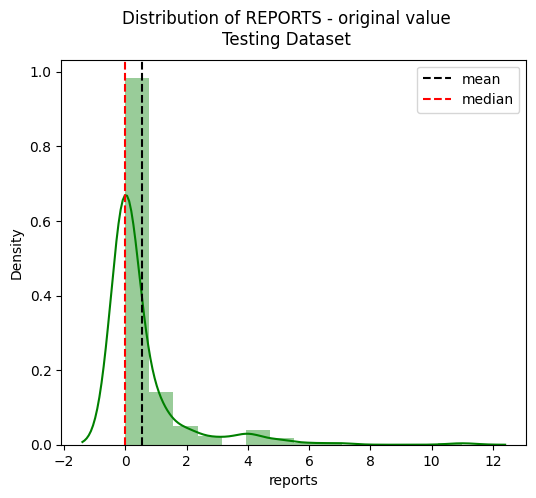

In [96]:
# Print the statistical information and histogram plot before data binning
x = df_test['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [97]:
# Execute the binning function
df_test = binning(df_test, 'reports', config["bins_reports"], config["labels_reports"])

# Check the binning result and compare it with the original `reports` value
df_test[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
214,3,2
215,1,1
216,0,0
217,1,1
218,0,0
219,0,0
220,0,0
221,0,0
222,1,1
223,0,0


count    224.000000
mean       0.303571
std        0.604012
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


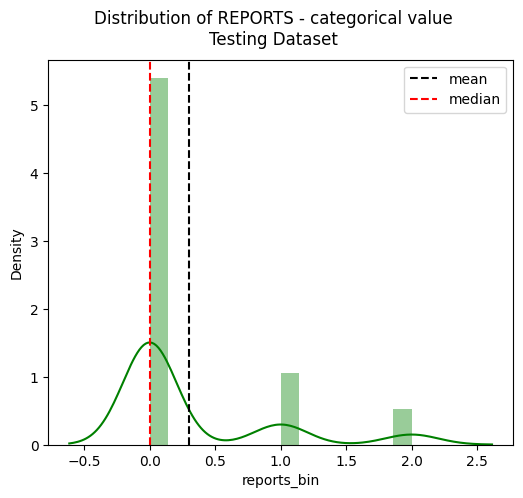

In [98]:
# Print the statistical information and histogram plot after data binning
x = df_test['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [99]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

### `dependents`

For this feature, I categorize by the applicant's marital status and the number of children they have.

The category definition of this feature are:
+ 0: marital status is "single"
+ 1: married, without a child
+ 2: married with 1 or 2 children, "small family" 
+ 3: married with 3 or more children, "big family"



In [100]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 1.99, 3, 6]

# Create the instance for `reports` category labels
labels = [0, 1, 2, 3]

#### Training Data

count    903.000000
mean       1.006645
std        1.282649
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


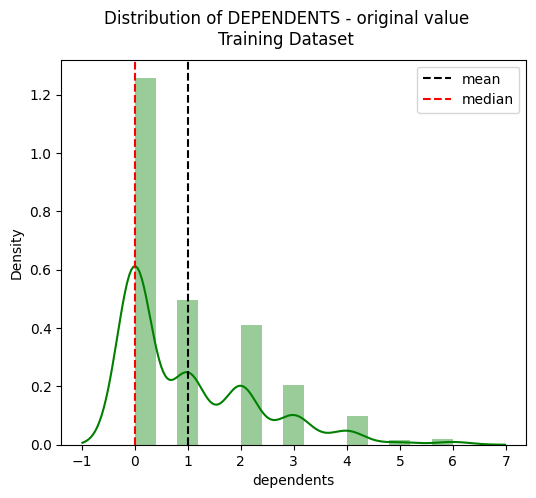

In [101]:
# Print the statistical information and histogram plot before data binning
x = df_train['dependents']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of DEPENDENTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [102]:
# Execute the binning function
df_train = binning(df_train, 'dependents', config["bins_dependents"], config["labels_dependents"])

# Check the binning result and compare it with the original `dependents` value
df_train[['dependents', 'dependents_bin']].tail(10)

,dependents,dependents_bin
893,0,0
894,2,2
895,2,2
896,1,1
897,2,2
898,1,1
899,1,1
900,0,0
901,0,0
902,2,2


count    903.000000
mean       0.849391
std        0.969329
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 0.0


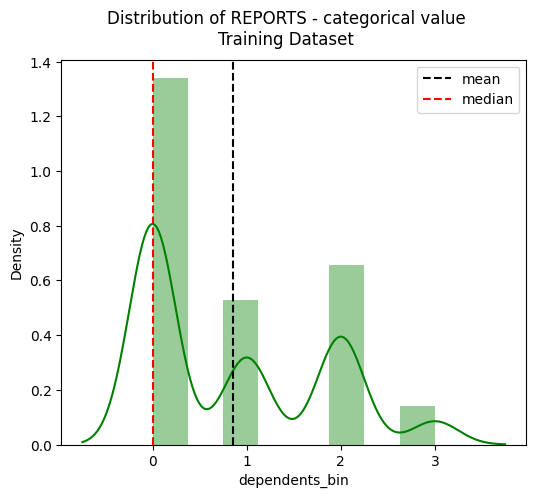

In [103]:
# Print the statistical information and histogram plot after data binning
x = df_train['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [104]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean       1.021622
std        1.197628
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: dependents, dtype: float64
Median: 1.0


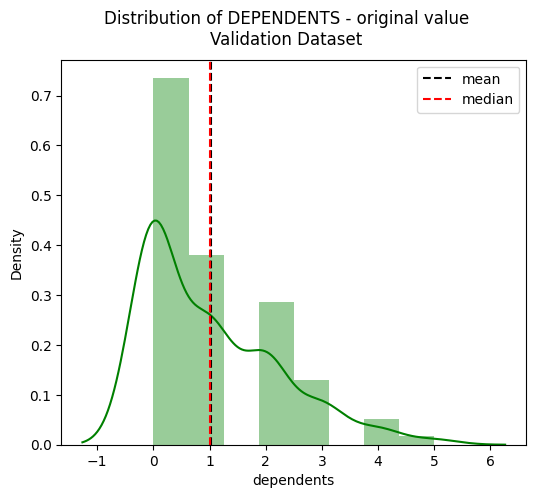

In [105]:
# Print the statistical information and histogram plot before data binning
x = df_valid['dependents']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of DEPENDENTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [106]:
# Execute the binning function
df_valid = binning(df_valid, 'dependents', config["bins_dependents"], config["labels_dependents"])

# Check the binning result and compare it with the original `dependents` value
df_valid[['dependents', 'dependents_bin']].tail(10)


,dependents,dependents_bin
175,0,0
176,3,2
177,0,0
178,0,0
179,2,2
180,3,2
181,0,0
182,0,0
183,0,0
184,0,0


count    185.000000
mean       0.886486
std        0.940098
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 1.0


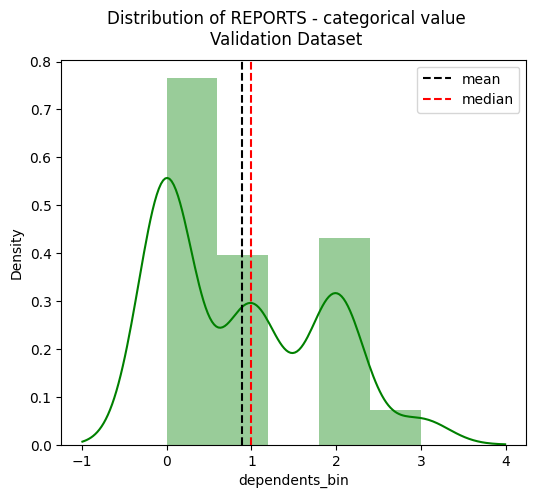

In [107]:
# Print the statistical information and histogram plot after data binning
x = df_valid['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [108]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

In [109]:
# Execute the binning function
df_test = binning(df_test, 'dependents', config["bins_dependents"], config["labels_dependents"])

# Check the binning result and compare it with the original `dependents` value
df_test[['dependents', 'dependents_bin']].tail(10)

,dependents,dependents_bin
214,3,2
215,0,0
216,0,0
217,0,0
218,0,0
219,0,0
220,2,2
221,2,2
222,2,2
223,1,1


count    224.000000
mean       0.790179
std        0.906228
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 0.0


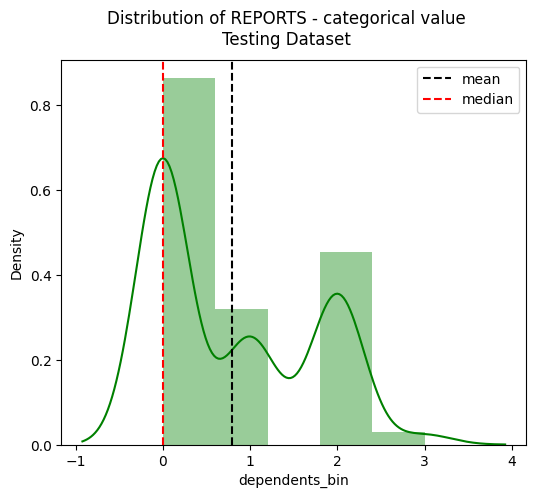

In [110]:
# Print the statistical information and histogram plot after data binning
x = df_test['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [111]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

### `active`

Based on [The New York Fed](https://www.newyorkfed.org/aboutthefed/whatwedo), average Americans have 5 - 6 active credit accounts, the detail can be read [in this link](https://www.newyorkfed.org/medialibrary/interactives/householdcredit/data/pdf/data_dictionary_HHDC.pdf) (page 2, section "Loan types").

The category definition of this feature are:
+ 0: zero active credit account
+ 1: 1 - 4 active credit accounts
+ 2: 5 - 6 active credit accounts, the typical group
+ 3: more than 6 active credit accounts

In [112]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 4, 6, 46]

# Create the instance for `reports` category labels
labels = [0, 1, 2, 3]

#### Training Data

count    903.000000
mean       6.929125
std        6.391640
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       46.000000
Name: active, dtype: float64
Median: 5.0


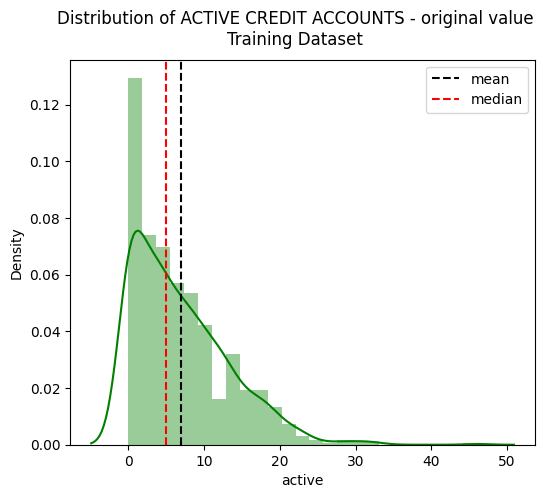

In [113]:
# Print the statistical information and histogram plot before data binning
x = df_train['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [114]:
# Execute the binning function
df_train = binning(df_train, 'active', config["bins_active"], config["labels_active"])

# Check the binning result and compare it with the original `active` value
df_train[['active', 'active_bin']].tail(10)

,active,active_bin
893,6,2
894,13,3
895,11,3
896,8,3
897,8,3
898,12,3
899,0,0
900,17,3
901,0,0
902,15,3


count    903.000000
mean       1.828350
std        1.183963
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 2.0


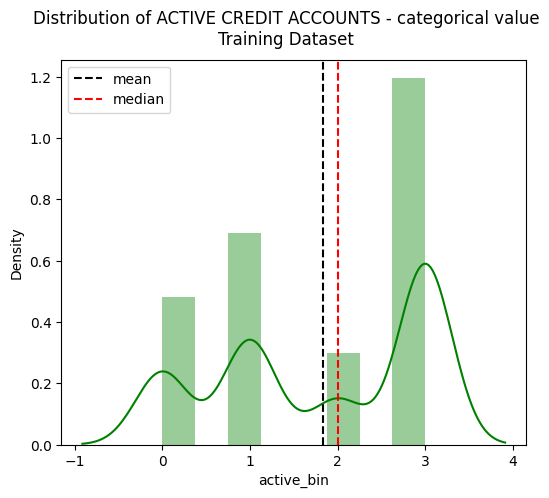

In [115]:
# Print the statistical information and histogram plot after data binning
x = df_train['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [116]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean       6.345946
std        5.701763
min        0.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       27.000000
Name: active, dtype: float64
Median: 5.0


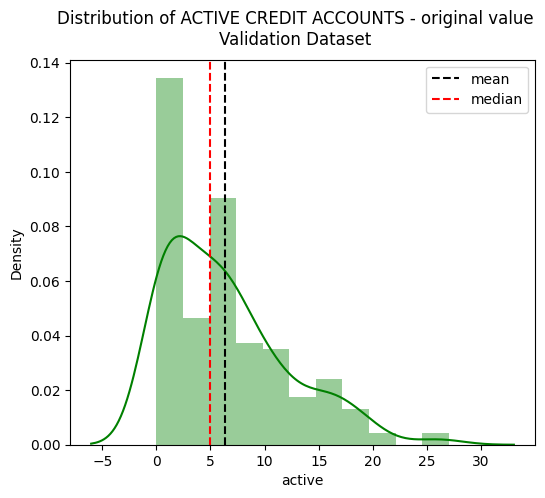

In [117]:
# Print the statistical information and histogram plot before data binning
x = df_valid['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [118]:
# Execute the binning function
df_valid = binning(df_valid, 'active', config["bins_active"], config["labels_active"])

# Check the binning result and compare it with the original `active` value
df_valid[['active', 'active_bin']].tail(10)

,active,active_bin
175,10,3
176,2,1
177,1,1
178,1,1
179,9,3
180,6,2
181,15,3
182,2,1
183,7,3
184,0,0


count    185.000000
mean       1.794595
std        1.147290
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 2.0


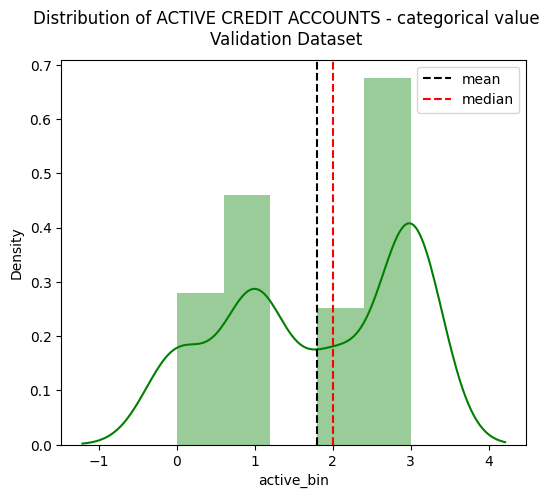

In [119]:
# Print the statistical information and histogram plot after data binning
x = df_valid['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [120]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

count    224.000000
mean       7.821429
std        6.426842
min        0.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       44.000000
Name: active, dtype: float64
Median: 7.0


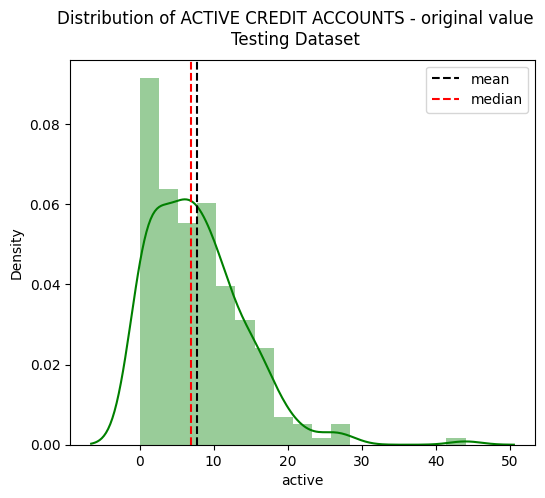

In [121]:
# Print the statistical information and histogram plot before data binning
x = df_test['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [122]:
# Execute the binning function
df_test = binning(df_test, 'active', config["bins_active"], config["labels_active"])

# Check the binning result and compare it with the original `active` value
df_test[['active', 'active_bin']].tail(10)

,active,active_bin
214,8,3
215,7,3
216,1,1
217,6,2
218,1,1
219,1,1
220,12,3
221,16,3
222,16,3
223,2,1


count    224.000000
mean       2.075893
std        1.103825
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 3.0


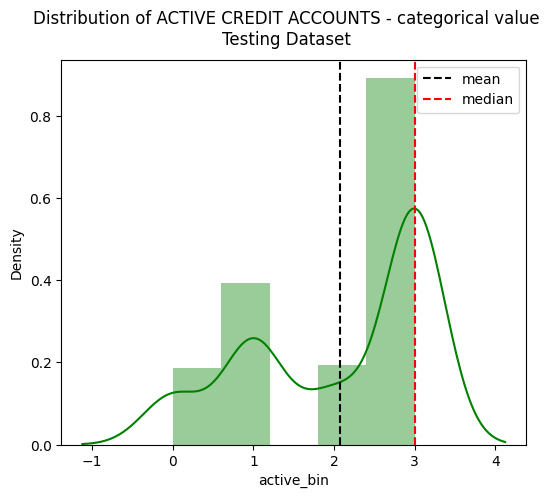

In [123]:
# Print the statistical information and histogram plot after data binning
x = df_test['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [124]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

# Feature Engineering


## Value Division on the `log_income` Feature

The `log_income` feature values are annual while the `log_expenditure` feature values are monthly, and to make their values conform, I decide to divide the `log_income` feature values by 12.


In [125]:
# Create the function for value division
def division(dataset, col):
    """A function to get the monthly value from any feature in the dataset that have annual value."""

    dataset[col] = dataset[col] / 12
    return dataset

### Training Data


In [126]:
# Execute the value division function
df_train = division(df_train, 'income_log')

# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

### Validation Data 


In [127]:
# Execute the value division function
df_valid = division(df_valid, 'income_log')

# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][0])

### Testing Data

In [128]:
# Execute the value division function
df_test = division(df_test, 'income_log')

# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][0])

## Data Balancing

The dependent variable is imbalance, it has an uneven distribution of observations.

This means that a dataset is biased towards a class in the dataset. If the dataset is biased towards one class, an algorithm trained on the same data will be biased towards the same class.

In [129]:
# Recheck the target data distribution
print(f"y_train value counts\n{df_train.card.value_counts()}")
print(f"\n--------------------------")
print(f"y_train value proportion\n{df_train.card.value_counts(normalize = True)}")

y_train value counts
1    700
0    203
Name: card, dtype: int64

--------------------------
y_train value proportion
1    0.775194
0    0.224806
Name: card, dtype: float64


Data balancing treatment will only be applied on the training dataset, there are 3 data balacning methods using the imblearn library, e.g. random undersampling, random oversampling, and SMOTE.

In [130]:
# Create the data balancing function
def balancing(dataset, 
              save_file = True,
              return_file = True):
    """A function to handle the dataset with imbalance target with various method from the imblearn library.
    x = the predictors in dataset, and y = the target in dataset,
    both method creates new x and y as data length changed,
    the new x and y dataframes are saved as pickle files"""

    y = dataset['card']
    x = dataset.drop(['card'], axis = 1)
    
    x_train_rus, y_train_rus = RandomUnderSampler(random_state = 46).fit_resample(x, y)
    x_train_ros, y_train_ros = RandomOverSampler(random_state = 85).fit_resample(x, y)
    x_train_smote, y_train_smote = SMOTE(random_state = 1205).fit_resample(x, y)

    if save_file:
        utils.pkl_dump(x_train_rus, config["dataset_train_balanced_path"][0])
        utils.pkl_dump(y_train_rus, config["dataset_train_balanced_path"][1])
        utils.pkl_dump(x_train_ros, config["dataset_train_balanced_path"][2])
        utils.pkl_dump(y_train_ros, config["dataset_train_balanced_path"][3])
        utils.pkl_dump(x_train_smote, config["dataset_train_balanced_path"][4])
        utils.pkl_dump(y_train_smote, config["dataset_train_balanced_path"][5])
        
    if return_file: 
        return x_train_rus, y_train_rus, \
               x_train_ros, y_train_ros, \
               x_train_smote, y_train_smote
    

In [131]:
# Execute the data balancing function
x_train_rus, y_train_rus, x_train_ros, y_train_ros, x_train_smote, y_train_smote = balancing(df_train)

# Check the dependent variable distribution after data balancing
print(f"balanced y_train value counts with random undersampler \n{y_train_rus.value_counts()}")
print(f"balanced y_train value counts with random oversampler \n{y_train_ros.value_counts()}")
print(f"balanced y_train value counts with SMOTE \n{y_train_smote.value_counts()}")

balanced y_train value counts with random undersampler 
0    203
1    203
Name: card, dtype: int64
balanced y_train value counts with random oversampler 
1    700
0    700
Name: card, dtype: int64
balanced y_train value counts with SMOTE 
1    700
0    700
Name: card, dtype: int64


# Modelling

Please continue to "4. modelling.ipynb" notebook.